In [1]:
%matplotlib inline
import copy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from alphamind.api import *
from PyFin.api import *
from PyFin.Math.Accumulators.StatefulAccumulators import MovingAverage
from PyFin.Math.Accumulators.StatefulAccumulators import MovingSharp
from PyFin.Math.Accumulators.StatefulAccumulators import MovingMaxDrawdown

plt.style.use('ggplot')

In [87]:
start_date = '2012-01-01'
end_date = '2018-01-11'
benchmark_code = 300
universe_name = ['zz800']
universe = Universe(universe_name, universe_name)
frequency = '5b'
batch = 16
method = 'risk_neutral'
neutralize_risk = ['SIZE', 'LEVERAGE'] + industry_styles
constraint_risk = ['SIZE', 'LEVERAGE'] + industry_styles

horizon = map_freq(frequency)
hedging_ratio = 0.

executor = NaiveExecutor()

In [88]:
engine = SqlEngine()
#factor_coverage = engine.fetch_factor_coverage()

In [108]:
#res = factor_coverage[(factor_coverage.universe == 'ashare_ex') & (factor_coverage.source != 'risk_exposure')].groupby('factor').mean().sort_values('coverage', ascending=False)
#model_features = sorted(res[res.coverage >= 0.99].index.unique().tolist())

base1 = LAST('roe_q')
base2 = CSRes(LAST('ep_q'), 'roe_q')

const_features_keys = {
                       'f01': base1,
                       'f02': base2,
                       'f03': CSRes(CSRes('cfinc1_q', base1), base2),
                       'f04': CSRes(CSRes('GREV', base1), base2),
                       'f05': CSRes(CSRes('ILLIQUIDITY', base1), base2),
                       'f06': CSRes(CSRes('RecievableTO', base1), base2),
                       'f07': CSRes(CSRes('ep_q_d_1w', base1), base2),
                       'f08': -CSRes(CSRes('Volatility', base1), base2)
                      }


model_features = copy.deepcopy(const_features_keys)

const_weights = [
                 0.0,
                 0.0,
                 0.0,
                 0.0,
                 0.0,
                 0.0,
                 0.0,
                 1.0
                ]

In [109]:
"""
Data phase
"""

engine = SqlEngine()

model_factor_data = fetch_data_package(engine,
                                       alpha_factors=model_features,
                                       start_date=start_date,
                                       end_date=end_date,
                                       frequency=frequency,
                                       universe=universe,
                                       benchmark=benchmark_code,
                                       batch=batch,
                                       neutralized_risk=neutralize_risk,
                                       pre_process=[winsorize_normal, standardize],
                                       post_process=[winsorize_normal, standardize],
                                       warm_start=batch)

model_features_keys = model_factor_data['x_names']

train_x = model_factor_data['train']['x']
train_y = model_factor_data['train']['y']
train_risk = model_factor_data['train']['risk']
ref_dates = sorted(train_x.keys())

predict_x = model_factor_data['predict']['x']
predict_y = model_factor_data['predict']['y']
predict_risk = model_factor_data['predict']['risk']
predict_code = model_factor_data['predict']['code']
settlement = model_factor_data['settlement']

2018-01-17 18:49:49,257 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-01-17 18:49:58,764 - ALPHA_MIND - INFO - factor data loading finished
2018-01-17 18:50:08,294 - ALPHA_MIND - INFO - return data loading finished
2018-01-17 18:50:10,178 - ALPHA_MIND - INFO - industry data loading finished
2018-01-17 18:50:10,676 - ALPHA_MIND - INFO - benchmark data loading finished
2018-01-17 18:50:20,551 - ALPHA_MIND - INFO - risk data loading finished
2018-01-17 18:50:22,816 - ALPHA_MIND - INFO - data merging finished
2018-01-17 18:50:24,534 - ALPHA_MIND - INFO - Loading data is finished
2018-01-17 18:50:33,509 - ALPHA_MIND - INFO - Data processing is finished


In [110]:
model_features_keys

['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08']

In [111]:
# for key, val in train_y.items():
#     train_y[key] = np.where(val > 0., 1, 0)
    
# for key, val in predict_y.items():
#     predict_y[key] = np.where(val > 0., 1, 0)

In [112]:
def cross_product(x, y):
    n, m = x.shape
    res = []
    
    for j in range(m):
        res.append(x[:, [j]] * y)
        
    return np.concatenate(res, axis=1)

In [113]:
%%time

"""
Training phase
"""

xgb_models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    if len(x) > 5 * len(model_features_keys):
        #model = RandomForestClassifier(n_estimators=2000, max_features='sqrt', max_depth=3, n_jobs=-1, features=model_features_keys)
        model = XGBTrainer(features=model_features_keys,
                           objective='reg:linear',
                           booster='gbtree',
                           tree_method='hist',
                           n_estimators=1,
                           learning_rate=0.01,
                           early_stopping_rounds=1,
                           subsample=0.25,
                           colsample_bytree=1.,
                           eval_sample=0.3)
        model.fit(x, y)
        xgb_models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-01-17 18:50:33,972 - ALPHA_MIND - INFO - trade_date: 2012-02-22 00:00:00 with 12599 obs training finished
2018-01-17 18:50:33,992 - ALPHA_MIND - INFO - trade_date: 2012-02-29 00:00:00 with 12595 obs training finished
2018-01-17 18:50:34,044 - ALPHA_MIND - INFO - trade_date: 2012-03-07 00:00:00 with 12591 obs training finished
2018-01-17 18:50:34,067 - ALPHA_MIND - INFO - trade_date: 2012-03-14 00:00:00 with 12586 obs training finished
2018-01-17 18:50:34,087 - ALPHA_MIND - INFO - trade_date: 2012-03-21 00:00:00 with 12584 obs training finished
2018-01-17 18:50:34,109 - ALPHA_MIND - INFO - trade_date: 2012-03-28 00:00:00 with 12581 obs training finished
2018-01-17 18:50:34,130 - ALPHA_MIND - INFO - trade_date: 2012-04-09 00:00:00 with 12578 obs training finished
2018-01-17 18:50:34,151 - ALPHA_MIND - INFO - trade_date: 2012-04-16 00:00:00 with 12578 obs training finished
2018-01-17 18:50:34,173 - ALPHA_MIND - INFO - trade_date: 2012-04-23 00:00:00 with 12578 obs training finished
2

2018-01-17 18:50:35,535 - ALPHA_MIND - INFO - trade_date: 2013-08-23 00:00:00 with 12531 obs training finished
2018-01-17 18:50:35,556 - ALPHA_MIND - INFO - trade_date: 2013-08-30 00:00:00 with 12522 obs training finished
2018-01-17 18:50:35,576 - ALPHA_MIND - INFO - trade_date: 2013-09-06 00:00:00 with 12512 obs training finished
2018-01-17 18:50:35,595 - ALPHA_MIND - INFO - trade_date: 2013-09-13 00:00:00 with 12503 obs training finished
2018-01-17 18:50:35,617 - ALPHA_MIND - INFO - trade_date: 2013-09-24 00:00:00 with 12494 obs training finished
2018-01-17 18:50:35,637 - ALPHA_MIND - INFO - trade_date: 2013-10-08 00:00:00 with 12484 obs training finished
2018-01-17 18:50:35,657 - ALPHA_MIND - INFO - trade_date: 2013-10-15 00:00:00 with 12473 obs training finished
2018-01-17 18:50:35,677 - ALPHA_MIND - INFO - trade_date: 2013-10-22 00:00:00 with 12463 obs training finished
2018-01-17 18:50:35,699 - ALPHA_MIND - INFO - trade_date: 2013-10-29 00:00:00 with 12452 obs training finished
2

2018-01-17 18:50:36,997 - ALPHA_MIND - INFO - trade_date: 2015-02-27 00:00:00 with 12186 obs training finished
2018-01-17 18:50:37,017 - ALPHA_MIND - INFO - trade_date: 2015-03-06 00:00:00 with 12182 obs training finished
2018-01-17 18:50:37,036 - ALPHA_MIND - INFO - trade_date: 2015-03-13 00:00:00 with 12183 obs training finished
2018-01-17 18:50:37,055 - ALPHA_MIND - INFO - trade_date: 2015-03-20 00:00:00 with 12185 obs training finished
2018-01-17 18:50:37,077 - ALPHA_MIND - INFO - trade_date: 2015-03-27 00:00:00 with 12187 obs training finished
2018-01-17 18:50:37,099 - ALPHA_MIND - INFO - trade_date: 2015-04-03 00:00:00 with 12189 obs training finished
2018-01-17 18:50:37,118 - ALPHA_MIND - INFO - trade_date: 2015-04-13 00:00:00 with 12193 obs training finished
2018-01-17 18:50:37,138 - ALPHA_MIND - INFO - trade_date: 2015-04-20 00:00:00 with 12208 obs training finished
2018-01-17 18:50:37,158 - ALPHA_MIND - INFO - trade_date: 2015-04-27 00:00:00 with 12225 obs training finished
2

2018-01-17 18:50:38,512 - ALPHA_MIND - INFO - trade_date: 2016-08-26 00:00:00 with 12399 obs training finished
2018-01-17 18:50:38,534 - ALPHA_MIND - INFO - trade_date: 2016-09-02 00:00:00 with 12394 obs training finished
2018-01-17 18:50:38,554 - ALPHA_MIND - INFO - trade_date: 2016-09-09 00:00:00 with 12389 obs training finished
2018-01-17 18:50:38,574 - ALPHA_MIND - INFO - trade_date: 2016-09-20 00:00:00 with 12386 obs training finished
2018-01-17 18:50:38,596 - ALPHA_MIND - INFO - trade_date: 2016-09-27 00:00:00 with 12383 obs training finished
2018-01-17 18:50:38,617 - ALPHA_MIND - INFO - trade_date: 2016-10-11 00:00:00 with 12380 obs training finished
2018-01-17 18:50:38,639 - ALPHA_MIND - INFO - trade_date: 2016-10-18 00:00:00 with 12375 obs training finished
2018-01-17 18:50:38,659 - ALPHA_MIND - INFO - trade_date: 2016-10-25 00:00:00 with 12371 obs training finished
2018-01-17 18:50:38,681 - ALPHA_MIND - INFO - trade_date: 2016-11-01 00:00:00 with 12368 obs training finished
2

Wall time: 5.91 s


In [114]:
const_model = ConstLinearModel(features=const_features_keys,
                               weights=const_weights)

const_model_factor_data = engine.fetch_data_range(universe,
                                                  const_features_keys,
                                                  dates=ref_dates,
                                                  benchmark=benchmark_code)['factor']

horizon = map_freq(frequency)

2018-01-17 18:52:23,078 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 798


start 0.02 weight gap simulation ...
using backbone model and alpha model


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-01-17 18:52:23,249 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-17 18:52:23,255 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:23,515 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-17 18:52:23,521 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:52:23,774 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-17 18:52:23,779 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:52:24,026 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-17 18:52:24,031 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:52:24,276 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-17 18:52:24,281 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:52:24,523 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-17 18:52:24,527 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:24,767 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-17 18:52:24,773 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:25,017 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-17 18:52:25,023 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:25,272 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-17 18:52:25,276 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:25,528 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-17 18:52:25,533 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:25,784 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-17 18:52:25,791 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:26,032 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-17 18:52:26,037 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:26,445 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-17 18:52:26,450 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:26,700 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-17 18:52:26,705 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:26,950 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-17 18:52:26,955 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:27,194 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-17 18:52:27,198 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:27,440 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-17 18:52:27,445 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:27,684 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-17 18:52:27,689 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:27,929 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-17 18:52:27,934 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:28,183 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-17 18:52:28,188 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:28,426 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-17 18:52:28,432 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:52:28,675 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-17 18:52:28,680 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:28,920 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-17 18:52:28,925 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:29,168 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-17 18:52:29,173 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:29,423 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-17 18:52:29,428 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:29,673 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-17 18:52:29,678 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:29,927 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-17 18:52:29,932 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:30,181 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-17 18:52:30,186 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:30,425 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-17 18:52:30,430 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:30,680 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-17 18:52:30,685 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:30,929 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-17 18:52:30,935 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:31,189 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-17 18:52:31,194 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:31,430 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-17 18:52:31,436 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:31,677 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-17 18:52:31,682 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:32,038 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-17 18:52:32,044 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:32,294 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-17 18:52:32,299 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:32,552 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-17 18:52:32,559 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:32,793 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-17 18:52:32,798 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:33,051 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-17 18:52:33,056 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:33,299 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-17 18:52:33,305 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:33,551 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-17 18:52:33,556 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:33,796 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-17 18:52:33,801 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:34,047 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-17 18:52:34,051 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:34,300 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-17 18:52:34,305 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:34,544 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-17 18:52:34,549 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:34,794 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-17 18:52:34,799 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:35,049 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-17 18:52:35,055 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:35,293 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-17 18:52:35,298 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:35,548 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-17 18:52:35,553 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:35,797 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-17 18:52:35,803 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:36,044 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-17 18:52:36,049 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:36,297 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-17 18:52:36,303 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:36,551 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-17 18:52:36,556 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:36,801 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-17 18:52:36,806 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:37,049 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-17 18:52:37,054 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:37,305 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-17 18:52:37,311 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:37,680 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-17 18:52:37,685 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:37,923 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-17 18:52:37,929 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:38,177 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-17 18:52:38,182 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:38,444 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-17 18:52:38,449 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:38,699 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-17 18:52:38,705 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:38,963 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-17 18:52:38,968 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:39,215 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-17 18:52:39,220 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:39,476 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-17 18:52:39,481 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:39,729 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-17 18:52:39,733 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:39,972 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-17 18:52:39,977 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:40,221 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-17 18:52:40,226 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:40,466 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-17 18:52:40,471 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:40,712 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-17 18:52:40,717 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:40,961 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-17 18:52:40,965 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:41,204 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-17 18:52:41,211 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:41,449 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-17 18:52:41,454 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:41,693 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-17 18:52:41,699 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:41,950 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-17 18:52:41,954 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:42,194 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-17 18:52:42,198 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:42,444 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-17 18:52:42,449 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:42,705 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-17 18:52:42,712 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:52:42,960 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-17 18:52:42,965 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:43,335 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-17 18:52:43,340 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:43,594 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-17 18:52:43,599 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:43,851 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-17 18:52:43,857 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:44,104 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-17 18:52:44,110 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:44,352 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-17 18:52:44,358 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:44,602 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-17 18:52:44,608 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:44,849 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-17 18:52:44,855 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:45,100 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-17 18:52:45,107 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:45,351 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-17 18:52:45,356 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:45,603 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-17 18:52:45,609 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:45,851 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-17 18:52:45,857 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:46,100 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-17 18:52:46,105 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:46,355 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-17 18:52:46,361 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:46,618 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-17 18:52:46,623 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:46,879 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-17 18:52:46,884 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:47,136 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-17 18:52:47,142 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:47,385 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-17 18:52:47,390 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:47,634 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-17 18:52:47,640 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:47,878 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-17 18:52:47,883 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:48,136 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-17 18:52:48,143 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:48,383 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-17 18:52:48,389 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:48,630 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-17 18:52:48,635 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:49,007 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-17 18:52:49,013 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:49,257 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-17 18:52:49,261 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:49,514 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-17 18:52:49,519 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:49,768 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-17 18:52:49,775 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:50,020 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-17 18:52:50,025 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:50,264 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-17 18:52:50,269 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:50,513 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-17 18:52:50,517 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:50,766 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-17 18:52:50,771 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:51,025 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-17 18:52:51,030 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:51,278 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-17 18:52:51,283 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:51,520 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-17 18:52:51,525 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:51,770 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-17 18:52:51,776 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:52,022 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-17 18:52:52,027 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:52,270 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-17 18:52:52,275 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:52,527 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-17 18:52:52,532 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:52,779 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-17 18:52:52,784 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:53,023 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-17 18:52:53,028 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:53,274 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-17 18:52:53,279 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:53,528 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-17 18:52:53,533 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:53,785 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-17 18:52:53,792 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:54,044 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-17 18:52:54,048 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:54,290 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-17 18:52:54,296 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:54,658 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-17 18:52:54,662 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:54,907 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-17 18:52:54,912 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:55,155 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-17 18:52:55,160 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:55,426 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-17 18:52:55,431 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:55,679 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-17 18:52:55,684 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:55,943 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-17 18:52:55,948 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:56,201 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-17 18:52:56,206 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:56,455 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-17 18:52:56,460 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:56,703 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-17 18:52:56,708 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:56,951 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-17 18:52:56,955 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:57,198 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-17 18:52:57,203 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:57,452 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-17 18:52:57,459 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:57,700 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-17 18:52:57,705 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:57,948 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-17 18:52:57,953 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:58,202 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-17 18:52:58,209 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:58,473 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-17 18:52:58,478 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:58,723 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-17 18:52:58,728 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:58,968 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-17 18:52:58,973 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:59,207 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-17 18:52:59,212 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:59,452 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-17 18:52:59,457 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:59,703 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-17 18:52:59,708 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:52:59,948 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-17 18:52:59,953 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:00,314 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-17 18:53:00,319 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:00,576 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-17 18:53:00,580 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:00,829 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-17 18:53:00,834 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:01,078 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-17 18:53:01,083 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:01,324 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-17 18:53:01,329 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:01,580 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-17 18:53:01,586 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:01,826 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-17 18:53:01,831 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:02,075 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-17 18:53:02,080 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:02,325 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-17 18:53:02,330 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:02,579 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-17 18:53:02,584 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:02,832 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-17 18:53:02,837 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:03,070 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-17 18:53:03,076 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:03,316 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-17 18:53:03,322 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:03,573 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-17 18:53:03,579 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:53:03,833 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-17 18:53:03,838 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:04,082 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-17 18:53:04,088 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:04,331 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-17 18:53:04,336 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:04,576 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-17 18:53:04,581 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:04,821 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-17 18:53:04,826 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:05,085 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-17 18:53:05,090 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:05,340 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-17 18:53:05,345 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:05,597 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-17 18:53:05,602 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:05,972 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-17 18:53:05,977 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:06,231 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-17 18:53:06,236 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:06,478 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-17 18:53:06,483 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:06,729 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-17 18:53:06,734 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:06,991 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-17 18:53:06,996 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:07,247 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-17 18:53:07,252 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:07,508 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-17 18:53:07,513 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:07,752 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-17 18:53:07,757 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:08,002 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-17 18:53:08,007 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:08,244 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-17 18:53:08,249 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:08,498 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-17 18:53:08,503 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:08,750 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-17 18:53:08,756 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:09,002 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-17 18:53:09,007 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:09,254 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-17 18:53:09,259 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:09,501 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-17 18:53:09,506 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:09,753 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-17 18:53:09,758 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:10,004 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-17 18:53:10,008 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:10,252 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-17 18:53:10,257 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:10,506 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-17 18:53:10,511 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:10,766 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-17 18:53:10,772 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:11,032 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-17 18:53:11,036 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:11,281 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-17 18:53:11,286 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:53:11,646 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-17 18:53:11,652 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:11,908 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-17 18:53:11,912 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:12,162 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-17 18:53:12,167 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:12,418 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-17 18:53:12,425 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:12,682 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-17 18:53:12,688 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:12,936 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-17 18:53:12,942 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:13,193 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-17 18:53:13,197 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:13,451 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-17 18:53:13,458 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:13,714 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-17 18:53:13,719 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:13,982 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-17 18:53:13,987 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:14,251 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-17 18:53:14,256 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:14,505 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-17 18:53:14,511 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:14,760 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-17 18:53:14,765 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:15,015 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-17 18:53:15,019 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:15,261 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-17 18:53:15,266 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:15,515 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-17 18:53:15,519 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:15,779 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-17 18:53:15,784 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:16,035 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-17 18:53:16,040 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:16,291 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-17 18:53:16,297 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:16,550 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-17 18:53:16,555 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:16,800 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-17 18:53:16,805 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:17,059 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-17 18:53:17,064 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:17,437 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-17 18:53:17,442 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:17,688 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-17 18:53:17,693 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:17,948 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-17 18:53:17,954 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:18,206 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-17 18:53:18,211 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:18,464 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-17 18:53:18,469 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:18,724 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-17 18:53:18,729 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:18,981 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-17 18:53:18,986 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:19,234 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-17 18:53:19,239 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:19,492 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-17 18:53:19,497 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:19,756 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-17 18:53:19,761 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:20,005 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-17 18:53:20,010 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:20,256 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-17 18:53:20,261 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:20,505 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-17 18:53:20,509 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:20,752 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-17 18:53:20,758 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:21,004 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-17 18:53:21,009 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:21,260 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-17 18:53:21,264 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:21,512 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-17 18:53:21,517 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:21,785 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-17 18:53:21,790 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:22,046 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-17 18:53:22,051 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:22,300 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-17 18:53:22,305 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:22,566 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-17 18:53:22,571 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:22,816 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-17 18:53:22,821 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:23,184 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-17 18:53:23,189 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:23,450 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-17 18:53:23,456 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:23,708 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-17 18:53:23,713 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:23,966 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-17 18:53:23,971 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:24,226 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-17 18:53:24,231 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:24,487 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-17 18:53:24,493 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:24,749 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-17 18:53:24,755 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:53:25,010 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-17 18:53:25,016 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:53:25,267 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-17 18:53:25,272 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:25,530 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-17 18:53:25,535 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:53:25,790 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-17 18:53:25,795 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:53:26,042 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-17 18:53:26,047 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:26,307 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-17 18:53:26,311 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:26,562 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-17 18:53:26,567 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:26,828 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-17 18:53:26,833 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:27,086 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-17 18:53:27,092 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:27,344 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-17 18:53:27,350 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:27,610 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-17 18:53:27,615 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:27,864 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-17 18:53:27,869 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:28,123 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-17 18:53:28,128 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:28,385 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-17 18:53:28,392 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:28,650 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-17 18:53:28,655 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:29,027 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-17 18:53:29,032 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:29,285 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-17 18:53:29,292 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:29,550 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-17 18:53:29,556 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:29,813 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-17 18:53:29,818 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:30,076 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-17 18:53:30,081 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:30,336 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-17 18:53:30,342 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:30,601 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-17 18:53:30,606 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:30,858 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-17 18:53:30,863 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:31,115 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-17 18:53:31,120 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:31,378 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-17 18:53:31,383 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:31,646 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-17 18:53:31,651 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:31,906 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-17 18:53:31,911 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:32,159 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-17 18:53:32,163 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:32,419 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-17 18:53:32,426 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:32,677 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-17 18:53:32,681 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:32,938 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-17 18:53:32,943 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:33,194 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-17 18:53:33,199 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:33,453 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-17 18:53:33,460 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:33,713 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-17 18:53:33,717 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:33,965 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-17 18:53:33,970 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:34,226 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-17 18:53:34,231 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:34,481 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-17 18:53:34,486 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:34,871 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-17 18:53:34,877 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:35,129 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-17 18:53:35,134 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:35,381 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-17 18:53:35,386 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:35,633 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-17 18:53:35,639 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:35,899 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-17 18:53:35,904 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:36,154 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-17 18:53:36,160 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:36,419 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-17 18:53:36,426 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:36,682 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-17 18:53:36,688 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:36,936 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-17 18:53:36,942 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:37,194 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-17 18:53:37,199 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:53:37,458 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished


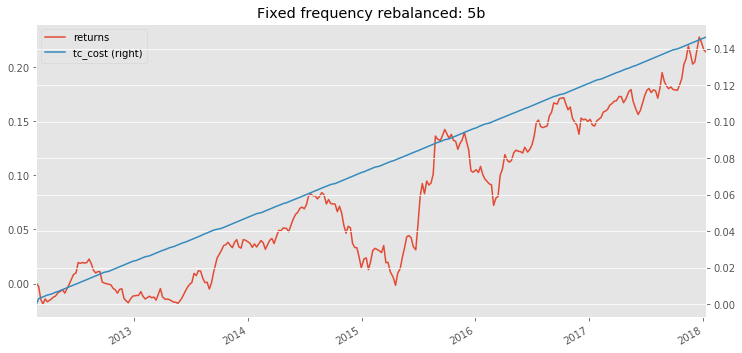

In [115]:
# Predicting and re-balance phase

weight_gaps = [0.020]

model1_weight = 1.0
model2_weight = 0.0

factor_groups = const_model_factor_data.groupby('trade_date')
turn_over_target_base = 0.25
size_risk_lower = 0
size_risk_upper = 0
benchmark_total_lower = 0.8
benchmark_total_upper = 1.
industry_lower = 1.
industry_upper = 1.

for s_i, weight_gap in enumerate(weight_gaps):
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[model_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values

        constraint_exp = total_data[constraint_risk].values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for j, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j],
                                           upper_bound=risk_target[j])
            elif name == 'SIZE':
                base_target = abs(risk_target[j])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] + base_target * size_risk_lower,
                                           upper_bound=risk_target[j] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] * industry_lower,
                                           upper_bound=risk_target[j] * industry_upper)
                
        values = total_data[model_features_keys].dropna()
        if values.empty:
            continue
        
        factor_values = factor_processing(total_data[model_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = xgb_models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_predict_code = predict_code[date]
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf2_{0}.csv'.format(int(s_i)))

## Lasso Regression
----------

In [63]:
"""
Training phase
"""

lasso_models_series = pd.Series()
previous_model = None

for ref_date in ref_dates:
    x = train_x[ref_date]
    y = train_y[ref_date]
    if len(x) > 5 * len(model_features_keys):
        model = LassoRegression(alpha=0.01, features=model_features_keys, fit_intercept=True) 
        model.fit(x, y)
        lasso_models_series.loc[ref_date] = model
        previous_model = copy.deepcopy(model)
    else:
        models_series.loc[ref_date] = previous_model
    
    alpha_logger.info('trade_date: {0} with {1} obs training finished'.format(ref_date, len(x)))

2018-01-17 18:15:16,068 - ALPHA_MIND - INFO - trade_date: 2012-02-22 00:00:00 with 12599 obs training finished
2018-01-17 18:15:16,074 - ALPHA_MIND - INFO - trade_date: 2012-02-29 00:00:00 with 12595 obs training finished
2018-01-17 18:15:16,081 - ALPHA_MIND - INFO - trade_date: 2012-03-07 00:00:00 with 12591 obs training finished
2018-01-17 18:15:16,088 - ALPHA_MIND - INFO - trade_date: 2012-03-14 00:00:00 with 12586 obs training finished
2018-01-17 18:15:16,096 - ALPHA_MIND - INFO - trade_date: 2012-03-21 00:00:00 with 12584 obs training finished
2018-01-17 18:15:16,105 - ALPHA_MIND - INFO - trade_date: 2012-03-28 00:00:00 with 12581 obs training finished
2018-01-17 18:15:16,119 - ALPHA_MIND - INFO - trade_date: 2012-04-09 00:00:00 with 12578 obs training finished
2018-01-17 18:15:16,126 - ALPHA_MIND - INFO - trade_date: 2012-04-16 00:00:00 with 12578 obs training finished
2018-01-17 18:15:16,133 - ALPHA_MIND - INFO - trade_date: 2012-04-23 00:00:00 with 12578 obs training finished
2

2018-01-17 18:15:16,626 - ALPHA_MIND - INFO - trade_date: 2013-08-30 00:00:00 with 12522 obs training finished
2018-01-17 18:15:16,632 - ALPHA_MIND - INFO - trade_date: 2013-09-06 00:00:00 with 12512 obs training finished
2018-01-17 18:15:16,639 - ALPHA_MIND - INFO - trade_date: 2013-09-13 00:00:00 with 12503 obs training finished
2018-01-17 18:15:16,645 - ALPHA_MIND - INFO - trade_date: 2013-09-24 00:00:00 with 12494 obs training finished
2018-01-17 18:15:16,653 - ALPHA_MIND - INFO - trade_date: 2013-10-08 00:00:00 with 12484 obs training finished
2018-01-17 18:15:16,660 - ALPHA_MIND - INFO - trade_date: 2013-10-15 00:00:00 with 12473 obs training finished
2018-01-17 18:15:16,668 - ALPHA_MIND - INFO - trade_date: 2013-10-22 00:00:00 with 12463 obs training finished
2018-01-17 18:15:16,675 - ALPHA_MIND - INFO - trade_date: 2013-10-29 00:00:00 with 12452 obs training finished
2018-01-17 18:15:16,681 - ALPHA_MIND - INFO - trade_date: 2013-11-05 00:00:00 with 12438 obs training finished
2

2018-01-17 18:15:17,192 - ALPHA_MIND - INFO - trade_date: 2015-03-06 00:00:00 with 12182 obs training finished
2018-01-17 18:15:17,199 - ALPHA_MIND - INFO - trade_date: 2015-03-13 00:00:00 with 12183 obs training finished
2018-01-17 18:15:17,206 - ALPHA_MIND - INFO - trade_date: 2015-03-20 00:00:00 with 12185 obs training finished
2018-01-17 18:15:17,213 - ALPHA_MIND - INFO - trade_date: 2015-03-27 00:00:00 with 12187 obs training finished
2018-01-17 18:15:17,222 - ALPHA_MIND - INFO - trade_date: 2015-04-03 00:00:00 with 12189 obs training finished
2018-01-17 18:15:17,231 - ALPHA_MIND - INFO - trade_date: 2015-04-13 00:00:00 with 12193 obs training finished
2018-01-17 18:15:17,237 - ALPHA_MIND - INFO - trade_date: 2015-04-20 00:00:00 with 12208 obs training finished
2018-01-17 18:15:17,242 - ALPHA_MIND - INFO - trade_date: 2015-04-27 00:00:00 with 12225 obs training finished
2018-01-17 18:15:17,250 - ALPHA_MIND - INFO - trade_date: 2015-05-05 00:00:00 with 12244 obs training finished
2

2018-01-17 18:15:17,726 - ALPHA_MIND - INFO - trade_date: 2016-08-26 00:00:00 with 12399 obs training finished
2018-01-17 18:15:17,733 - ALPHA_MIND - INFO - trade_date: 2016-09-02 00:00:00 with 12394 obs training finished
2018-01-17 18:15:17,740 - ALPHA_MIND - INFO - trade_date: 2016-09-09 00:00:00 with 12389 obs training finished
2018-01-17 18:15:17,748 - ALPHA_MIND - INFO - trade_date: 2016-09-20 00:00:00 with 12386 obs training finished
2018-01-17 18:15:17,755 - ALPHA_MIND - INFO - trade_date: 2016-09-27 00:00:00 with 12383 obs training finished
2018-01-17 18:15:17,763 - ALPHA_MIND - INFO - trade_date: 2016-10-11 00:00:00 with 12380 obs training finished
2018-01-17 18:15:17,770 - ALPHA_MIND - INFO - trade_date: 2016-10-18 00:00:00 with 12375 obs training finished
2018-01-17 18:15:17,778 - ALPHA_MIND - INFO - trade_date: 2016-10-25 00:00:00 with 12371 obs training finished
2018-01-17 18:15:17,785 - ALPHA_MIND - INFO - trade_date: 2016-11-01 00:00:00 with 12368 obs training finished
2

2018-01-17 18:07:21,063 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 798


start 0.005 weight gap simulation ...
using backbone model and alpha model


D:\ProgramData\IntelPython3_2018\lib\site-packages\ipykernel_launcher.py:76: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
2018-01-17 18:07:21,192 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-17 18:07:21,198 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:21,418 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-17 18:07:21,425 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 797
2018-01-17 18:07:21,635 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished

using backbone model and alpha model



2018-01-17 18:07:21,642 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:07:21,859 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-17 18:07:21,865 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:07:22,096 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-17 18:07:22,101 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 796
2018-01-17 18:07:22,310 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:07:22,316 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:22,534 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-17 18:07:22,540 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:22,759 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-17 18:07:22,765 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:23,114 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-17 18:07:23,119 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:23,342 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-17 18:07:23,347 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:23,568 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-17 18:07:23,574 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:23,795 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-17 18:07:23,801 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:24,020 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-17 18:07:24,027 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:24,241 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-17 18:07:24,247 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:24,474 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-17 18:07:24,481 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 798
2018-01-17 18:07:24,691 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:07:24,698 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:24,914 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-17 18:07:24,920 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:25,138 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-17 18:07:25,144 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:25,359 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-17 18:07:25,365 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:25,578 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-17 18:07:25,585 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:25,799 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-17 18:07:25,805 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:26,019 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-17 18:07:26,025 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:26,236 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-17 18:07:26,243 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:26,453 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-17 18:07:26,459 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:26,669 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-17 18:07:26,676 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 799
2018-01-17 18:07:26,878 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:07:26,885 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:27,096 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-17 18:07:27,103 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:27,316 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-17 18:07:27,323 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:27,533 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-17 18:07:27,540 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:27,765 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-17 18:07:27,771 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:27,982 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-17 18:07:27,989 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:28,209 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-17 18:07:28,216 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:28,552 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-17 18:07:28,559 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:28,780 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-17 18:07:28,786 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:29,001 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-17 18:07:29,008 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 799
2018-01-17 18:07:29,216 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:07:29,222 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:29,433 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-17 18:07:29,439 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:29,656 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-17 18:07:29,662 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 799
2018-01-17 18:07:29,872 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:07:29,879 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:30,097 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-17 18:07:30,104 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:30,329 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-17 18:07:30,336 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:30,548 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-17 18:07:30,555 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:30,780 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-17 18:07:30,786 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:30,998 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-17 18:07:31,005 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:31,218 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-17 18:07:31,223 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:31,443 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-17 18:07:31,450 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:31,675 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-17 18:07:31,682 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:31,895 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-17 18:07:31,902 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:32,127 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-17 18:07:32,133 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:32,350 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-17 18:07:32,356 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:32,584 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-17 18:07:32,590 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:32,808 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-17 18:07:32,815 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:33,038 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-17 18:07:33,045 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:33,278 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-17 18:07:33,284 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:33,501 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-17 18:07:33,508 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:33,734 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-17 18:07:33,740 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:34,096 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-17 18:07:34,101 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:34,325 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-17 18:07:34,331 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:34,565 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-17 18:07:34,570 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:34,796 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-17 18:07:34,802 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:35,023 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-17 18:07:35,030 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:35,262 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-17 18:07:35,267 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:35,490 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-17 18:07:35,497 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:35,719 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-17 18:07:35,724 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:35,936 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-17 18:07:35,943 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:36,154 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-17 18:07:36,160 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:36,380 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-17 18:07:36,387 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:36,605 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-17 18:07:36,611 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:36,827 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-17 18:07:36,833 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:37,053 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-17 18:07:37,060 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:37,282 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-17 18:07:37,287 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:37,506 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-17 18:07:37,513 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:37,732 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-17 18:07:37,737 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:37,958 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-17 18:07:37,964 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:38,183 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-17 18:07:38,190 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:38,412 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-17 18:07:38,418 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:38,644 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-17 18:07:38,650 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:07:38,882 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-17 18:07:38,887 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:39,132 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-17 18:07:39,138 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:39,367 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-17 18:07:39,373 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:39,713 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-17 18:07:39,720 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:39,953 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-17 18:07:39,958 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:40,188 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-17 18:07:40,194 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:40,420 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-17 18:07:40,427 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:40,645 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-17 18:07:40,652 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800
2018-01-17 18:07:40,862 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:07:40,869 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:41,102 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-17 18:07:41,107 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:41,328 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-17 18:07:41,335 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:41,547 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-17 18:07:41,554 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:41,774 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-17 18:07:41,780 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:42,003 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-17 18:07:42,009 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:42,236 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-17 18:07:42,243 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:42,472 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-17 18:07:42,479 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:42,711 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-17 18:07:42,717 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:42,934 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-17 18:07:42,941 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:43,175 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-17 18:07:43,180 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:43,406 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-17 18:07:43,412 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:43,631 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-17 18:07:43,637 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:43,858 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-17 18:07:43,865 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:44,084 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-17 18:07:44,091 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:44,314 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-17 18:07:44,319 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:44,536 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-17 18:07:44,542 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:44,772 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-17 18:07:44,779 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:45,121 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-17 18:07:45,127 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:45,355 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-17 18:07:45,361 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:45,581 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-17 18:07:45,587 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:45,810 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-17 18:07:45,816 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:46,033 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-17 18:07:46,038 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:46,260 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-17 18:07:46,266 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:46,483 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-17 18:07:46,490 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:46,709 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-17 18:07:46,716 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:46,939 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-17 18:07:46,946 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:47,156 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-17 18:07:47,162 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:47,376 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-17 18:07:47,382 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:47,600 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-17 18:07:47,606 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800
2018-01-17 18:07:47,815 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:07:47,822 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:48,043 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-17 18:07:48,049 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:48,272 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-17 18:07:48,278 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:48,498 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-17 18:07:48,504 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:48,720 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-17 18:07:48,726 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:48,940 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-17 18:07:48,947 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:49,167 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-17 18:07:49,173 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:49,388 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-17 18:07:49,395 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:49,615 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-17 18:07:49,621 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:49,845 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-17 18:07:49,850 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:50,076 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-17 18:07:50,082 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:50,415 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-17 18:07:50,422 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:50,654 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-17 18:07:50,662 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:50,892 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-17 18:07:50,897 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:51,115 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-17 18:07:51,121 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:51,341 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-17 18:07:51,346 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:51,578 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-17 18:07:51,583 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:51,803 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-17 18:07:51,809 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:52,026 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-17 18:07:52,032 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:52,254 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-17 18:07:52,261 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:52,477 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-17 18:07:52,483 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:52,703 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-17 18:07:52,709 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:52,938 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-17 18:07:52,944 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:53,165 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-17 18:07:53,172 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:53,391 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-17 18:07:53,397 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:53,620 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-17 18:07:53,627 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:53,851 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-17 18:07:53,858 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:54,083 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-17 18:07:54,089 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:54,315 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-17 18:07:54,321 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:54,542 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-17 18:07:54,547 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:54,777 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-17 18:07:54,783 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:55,010 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-17 18:07:55,018 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:55,239 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-17 18:07:55,245 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:55,470 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-17 18:07:55,477 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:55,706 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-17 18:07:55,712 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:56,058 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-17 18:07:56,064 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:56,290 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-17 18:07:56,296 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:56,518 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-17 18:07:56,524 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:56,752 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-17 18:07:56,759 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:56,979 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-17 18:07:56,985 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:57,212 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-17 18:07:57,219 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:57,447 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-17 18:07:57,453 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:57,675 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-17 18:07:57,681 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:07:57,896 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-17 18:07:57,902 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:58,130 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-17 18:07:58,136 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:58,354 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-17 18:07:58,360 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:58,588 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-17 18:07:58,594 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:58,816 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-17 18:07:58,823 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:59,054 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-17 18:07:59,060 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:59,281 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-17 18:07:59,287 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:59,512 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-17 18:07:59,519 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:59,745 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-17 18:07:59,752 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:07:59,973 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-17 18:07:59,979 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:00,206 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-17 18:08:00,212 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:00,430 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-17 18:08:00,436 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:00,660 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-17 18:08:00,667 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:00,884 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-17 18:08:00,891 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:01,115 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-17 18:08:01,121 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:01,461 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-17 18:08:01,468 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:01,699 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-17 18:08:01,705 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:01,947 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-17 18:08:01,952 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:02,181 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-17 18:08:02,187 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:02,405 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-17 18:08:02,412 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:02,638 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-17 18:08:02,644 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:02,867 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-17 18:08:02,873 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:03,103 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-17 18:08:03,109 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:03,341 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-17 18:08:03,347 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:03,576 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-17 18:08:03,583 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:03,814 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-17 18:08:03,820 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:04,060 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-17 18:08:04,066 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:04,309 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-17 18:08:04,314 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:04,543 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-17 18:08:04,550 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:04,777 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-17 18:08:04,783 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:04,999 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-17 18:08:05,005 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:05,223 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-17 18:08:05,230 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:05,463 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-17 18:08:05,469 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:05,698 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-17 18:08:05,703 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:05,929 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-17 18:08:05,935 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:06,167 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-17 18:08:06,173 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:06,413 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-17 18:08:06,418 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:06,663 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-17 18:08:06,669 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:06,902 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-17 18:08:06,908 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:07,266 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-17 18:08:07,271 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:07,521 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-17 18:08:07,526 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:07,756 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-17 18:08:07,762 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:07,986 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-17 18:08:07,991 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:08,208 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-17 18:08:08,215 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:08,446 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-17 18:08:08,452 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:08,684 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-17 18:08:08,690 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:08,919 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-17 18:08:08,925 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:09,149 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-17 18:08:09,155 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:09,379 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-17 18:08:09,384 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:09,614 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-17 18:08:09,620 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:09,846 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-17 18:08:09,853 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:10,067 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-17 18:08:10,074 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:10,298 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-17 18:08:10,304 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:10,534 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-17 18:08:10,540 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:10,777 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-17 18:08:10,783 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:11,010 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-17 18:08:11,015 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:11,247 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-17 18:08:11,252 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:11,483 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-17 18:08:11,490 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:11,727 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-17 18:08:11,733 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:11,965 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-17 18:08:11,970 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:12,200 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-17 18:08:12,205 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:12,431 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-17 18:08:12,438 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:12,784 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-17 18:08:12,790 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:13,018 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-17 18:08:13,024 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:13,254 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-17 18:08:13,260 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:13,489 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-17 18:08:13,495 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:13,722 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-17 18:08:13,729 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:13,959 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-17 18:08:13,965 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:14,195 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-17 18:08:14,201 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:14,424 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-17 18:08:14,430 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:14,680 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-17 18:08:14,685 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:14,907 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-17 18:08:14,913 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:15,153 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-17 18:08:15,158 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:15,395 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-17 18:08:15,400 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:15,628 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-17 18:08:15,635 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:15,870 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-17 18:08:15,876 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:16,104 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-17 18:08:16,110 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:16,338 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-17 18:08:16,343 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:16,571 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-17 18:08:16,577 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:16,816 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-17 18:08:16,821 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:17,042 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-17 18:08:17,049 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:17,280 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-17 18:08:17,286 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:17,507 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-17 18:08:17,514 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:17,747 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-17 18:08:17,752 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:17,974 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-17 18:08:17,980 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:18,322 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-17 18:08:18,328 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:18,566 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-17 18:08:18,572 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:18,813 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-17 18:08:18,819 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:19,051 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-17 18:08:19,057 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:19,290 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-17 18:08:19,296 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:19,536 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-17 18:08:19,541 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:19,783 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-17 18:08:19,788 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:20,016 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-17 18:08:20,022 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:20,250 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-17 18:08:20,257 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:20,488 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-17 18:08:20,494 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:20,730 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-17 18:08:20,736 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:20,972 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-17 18:08:20,978 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:21,222 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-17 18:08:21,227 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:21,465 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-17 18:08:21,470 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:21,707 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-17 18:08:21,712 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:21,942 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-17 18:08:21,947 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:22,180 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-17 18:08:22,185 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:22,420 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-17 18:08:22,426 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:22,652 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-17 18:08:22,657 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:22,886 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-17 18:08:22,892 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:23,117 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-17 18:08:23,123 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:23,377 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-17 18:08:23,383 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:23,610 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-17 18:08:23,615 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:23,845 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-17 18:08:23,851 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:24,196 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-17 18:08:24,201 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:24,442 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-17 18:08:24,447 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:24,678 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-17 18:08:24,684 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:24,918 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-17 18:08:24,924 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:25,151 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-17 18:08:25,158 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:25,388 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-17 18:08:25,394 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:25,618 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-17 18:08:25,624 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:25,857 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-17 18:08:25,862 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:26,104 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-17 18:08:26,110 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:26,346 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-17 18:08:26,351 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:26,584 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-17 18:08:26,589 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:26,829 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-17 18:08:26,834 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:27,070 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-17 18:08:27,076 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:27,317 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-17 18:08:27,323 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:27,559 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-17 18:08:27,564 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:27,796 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-17 18:08:27,802 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:28,044 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-17 18:08:28,049 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:28,294 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-17 18:08:28,299 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:28,528 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-17 18:08:28,534 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:28,758 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-17 18:08:28,764 - ALPHA_MIND - INFO - 2018-01-11 00:00:00: 800
2018-01-17 18:08:28,965 - ALPHA_MIND - INFO - 2018-01-11 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:08:29,758 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 798


start 0.01 weight gap simulation ...
using backbone model and alpha model


2018-01-17 18:08:30,051 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-17 18:08:30,057 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:30,297 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-17 18:08:30,302 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:08:30,526 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-17 18:08:30,533 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:08:30,770 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-17 18:08:30,778 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:08:31,035 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-17 18:08:31,042 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:08:31,285 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-17 18:08:31,291 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:31,513 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-17 18:08:31,520 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:31,752 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-17 18:08:31,760 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:32,008 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-17 18:08:32,013 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:32,226 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-17 18:08:32,233 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:32,462 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-17 18:08:32,468 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:32,698 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-17 18:08:32,703 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:32,921 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-17 18:08:32,928 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 798
2018-01-17 18:08:33,139 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:08:33,145 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:33,373 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-17 18:08:33,379 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:33,598 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-17 18:08:33,604 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:33,840 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-17 18:08:33,848 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:34,083 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-17 18:08:34,090 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:34,333 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-17 18:08:34,338 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:34,553 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-17 18:08:34,560 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:34,777 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-17 18:08:34,785 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:08:34,995 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-17 18:08:35,001 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 799
2018-01-17 18:08:35,211 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished

using backbone model and alpha model



2018-01-17 18:08:35,218 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 799
2018-01-17 18:08:35,427 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:08:35,433 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:35,768 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-17 18:08:35,774 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:35,985 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-17 18:08:35,991 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:36,204 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-17 18:08:36,209 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:36,421 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-17 18:08:36,427 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:36,646 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-17 18:08:36,652 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:36,881 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-17 18:08:36,887 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:37,105 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-17 18:08:37,111 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:37,351 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-17 18:08:37,356 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:37,570 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-17 18:08:37,577 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 799
2018-01-17 18:08:37,783 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:08:37,790 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:38,005 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-17 18:08:38,012 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:38,224 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-17 18:08:38,230 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:38,456 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished
2018-01-17 18:08:38,462 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:38,679 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-17 18:08:38,686 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:38,901 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-17 18:08:38,907 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:39,137 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-17 18:08:39,143 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:39,364 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-17 18:08:39,370 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 799
2018-01-17 18:08:39,579 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:08:39,586 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:39,800 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-17 18:08:39,806 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:40,019 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-17 18:08:40,026 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:40,240 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-17 18:08:40,246 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:40,459 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-17 18:08:40,466 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:40,699 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-17 18:08:40,704 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:40,930 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-17 18:08:40,936 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:41,294 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-17 18:08:41,300 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:41,523 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-17 18:08:41,530 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:41,749 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-17 18:08:41,755 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:41,969 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-17 18:08:41,975 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:42,199 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-17 18:08:42,206 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:42,431 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-17 18:08:42,439 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:42,664 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-17 18:08:42,670 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:42,896 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-17 18:08:42,902 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:43,125 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-17 18:08:43,131 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:43,347 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-17 18:08:43,354 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:43,587 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-17 18:08:43,593 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:43,827 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-17 18:08:43,832 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:44,054 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-17 18:08:44,061 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:44,288 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-17 18:08:44,295 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:44,517 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-17 18:08:44,524 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:44,740 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-17 18:08:44,746 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:44,967 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-17 18:08:44,973 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:45,194 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-17 18:08:45,200 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:45,415 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-17 18:08:45,422 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:45,645 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-17 18:08:45,652 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:45,883 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-17 18:08:45,889 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:46,105 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-17 18:08:46,111 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:46,330 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-17 18:08:46,336 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:46,552 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-17 18:08:46,558 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:46,902 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-17 18:08:46,908 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:47,141 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-17 18:08:47,147 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:47,373 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-17 18:08:47,379 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:47,602 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-17 18:08:47,608 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:47,832 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-17 18:08:47,838 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:08:48,064 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-17 18:08:48,070 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:48,304 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-17 18:08:48,309 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:48,542 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-17 18:08:48,547 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:48,775 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-17 18:08:48,782 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:49,004 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-17 18:08:49,010 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:49,229 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-17 18:08:49,235 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:49,454 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-17 18:08:49,460 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:49,680 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-17 18:08:49,686 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:49,909 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-17 18:08:49,915 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:50,137 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-17 18:08:50,144 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:50,371 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-17 18:08:50,378 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:50,595 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-17 18:08:50,600 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:50,817 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-17 18:08:50,824 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:51,047 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-17 18:08:51,052 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:51,283 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-17 18:08:51,288 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:51,516 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-17 18:08:51,522 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:51,747 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-17 18:08:51,753 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:51,970 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-17 18:08:51,975 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:52,202 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-17 18:08:52,208 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:52,567 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-17 18:08:52,573 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:52,791 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-17 18:08:52,798 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:53,017 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-17 18:08:53,023 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:53,248 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-17 18:08:53,254 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:53,475 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-17 18:08:53,482 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:53,706 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-17 18:08:53,712 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:53,930 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-17 18:08:53,936 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:54,148 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-17 18:08:54,154 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:54,372 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-17 18:08:54,378 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:54,605 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-17 18:08:54,611 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800
2018-01-17 18:08:54,825 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished

using backbone model and alpha model



2018-01-17 18:08:54,833 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:55,054 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-17 18:08:55,061 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:55,278 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-17 18:08:55,285 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:55,510 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-17 18:08:55,516 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:55,742 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-17 18:08:55,747 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:55,972 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-17 18:08:55,978 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:56,205 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-17 18:08:56,211 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:56,429 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-17 18:08:56,436 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:56,658 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-17 18:08:56,665 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:56,884 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-17 18:08:56,890 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:57,109 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-17 18:08:57,115 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:57,335 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-17 18:08:57,341 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:57,568 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-17 18:08:57,573 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:57,795 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-17 18:08:57,803 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:58,155 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-17 18:08:58,160 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:58,391 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-17 18:08:58,396 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:58,617 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-17 18:08:58,624 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:58,848 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-17 18:08:58,855 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:59,082 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-17 18:08:59,088 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:59,313 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-17 18:08:59,319 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:59,542 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-17 18:08:59,548 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:08:59,777 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-17 18:08:59,783 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:00,019 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-17 18:09:00,025 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:00,240 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-17 18:09:00,246 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:00,467 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-17 18:09:00,473 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:00,698 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-17 18:09:00,704 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:00,920 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-17 18:09:00,926 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:01,146 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-17 18:09:01,152 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:01,376 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-17 18:09:01,383 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:01,604 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-17 18:09:01,610 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:01,825 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-17 18:09:01,831 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:02,058 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-17 18:09:02,065 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:02,286 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-17 18:09:02,293 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:02,504 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-17 18:09:02,510 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:02,732 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-17 18:09:02,738 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:02,959 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-17 18:09:02,965 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:03,191 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-17 18:09:03,197 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:03,420 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-17 18:09:03,427 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:03,779 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-17 18:09:03,785 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:04,014 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-17 18:09:04,021 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:04,248 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-17 18:09:04,255 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:04,474 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-17 18:09:04,482 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:04,711 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-17 18:09:04,717 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:04,949 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-17 18:09:04,955 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:05,178 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-17 18:09:05,184 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:05,400 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-17 18:09:05,406 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:05,621 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-17 18:09:05,627 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:05,846 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-17 18:09:05,852 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:06,076 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-17 18:09:06,082 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:06,303 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-17 18:09:06,308 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:06,531 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-17 18:09:06,536 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:06,762 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-17 18:09:06,769 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:06,991 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-17 18:09:06,997 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:07,222 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-17 18:09:07,228 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:07,455 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-17 18:09:07,462 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:07,689 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-17 18:09:07,695 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:07,918 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-17 18:09:07,925 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:08,148 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-17 18:09:08,154 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:08,379 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-17 18:09:08,385 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:08,602 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-17 18:09:08,609 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:08,833 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-17 18:09:08,839 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:09,070 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-17 18:09:09,076 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:09,427 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-17 18:09:09,434 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:09,663 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-17 18:09:09,669 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:09,900 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-17 18:09:09,906 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:10,128 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-17 18:09:10,134 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:10,360 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-17 18:09:10,365 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:10,586 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-17 18:09:10,592 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:10,819 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-17 18:09:10,825 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:11,046 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-17 18:09:11,052 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:11,279 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-17 18:09:11,285 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:11,505 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-17 18:09:11,511 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:11,727 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-17 18:09:11,733 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:11,955 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-17 18:09:11,961 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:12,180 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-17 18:09:12,187 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:12,406 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-17 18:09:12,412 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:12,636 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-17 18:09:12,643 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:12,868 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-17 18:09:12,875 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:13,101 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-17 18:09:13,107 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:13,337 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-17 18:09:13,343 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:13,578 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-17 18:09:13,584 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:13,808 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-17 18:09:13,814 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:14,047 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-17 18:09:14,053 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:14,274 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-17 18:09:14,281 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:14,505 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-17 18:09:14,511 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:14,735 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-17 18:09:14,741 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:15,094 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-17 18:09:15,100 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:15,325 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-17 18:09:15,332 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:15,556 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-17 18:09:15,562 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:15,804 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-17 18:09:15,809 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:16,043 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-17 18:09:16,049 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:16,296 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-17 18:09:16,301 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:16,543 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-17 18:09:16,548 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:16,775 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-17 18:09:16,782 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:17,012 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-17 18:09:17,017 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:17,245 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-17 18:09:17,251 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:17,477 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-17 18:09:17,483 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:17,716 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-17 18:09:17,722 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:17,951 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-17 18:09:17,957 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:18,183 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-17 18:09:18,189 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:18,408 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-17 18:09:18,415 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:18,639 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-17 18:09:18,644 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:18,876 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-17 18:09:18,881 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:19,108 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-17 18:09:19,114 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:19,344 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-17 18:09:19,350 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:19,587 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-17 18:09:19,592 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:19,832 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-17 18:09:19,837 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:20,061 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-17 18:09:20,067 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:20,294 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-17 18:09:20,299 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:20,514 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-17 18:09:20,520 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:20,874 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-17 18:09:20,880 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:21,110 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-17 18:09:21,115 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:21,339 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-17 18:09:21,345 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:21,574 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-17 18:09:21,581 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:21,807 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-17 18:09:21,813 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:22,049 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-17 18:09:22,055 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:22,290 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-17 18:09:22,295 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:22,522 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-17 18:09:22,528 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:22,758 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-17 18:09:22,764 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:22,996 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-17 18:09:23,002 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:23,231 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-17 18:09:23,236 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:23,457 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-17 18:09:23,462 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:23,690 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-17 18:09:23,696 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:23,932 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-17 18:09:23,938 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:24,161 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-17 18:09:24,167 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:24,394 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-17 18:09:24,399 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:24,625 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-17 18:09:24,631 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:24,860 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-17 18:09:24,867 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:25,093 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-17 18:09:25,099 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:25,331 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-17 18:09:25,337 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:25,561 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-17 18:09:25,568 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:25,811 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-17 18:09:25,816 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:26,036 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-17 18:09:26,042 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:26,261 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-17 18:09:26,267 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:26,616 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-17 18:09:26,622 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:26,857 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-17 18:09:26,863 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:27,084 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-17 18:09:27,091 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:27,312 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-17 18:09:27,318 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:27,551 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-17 18:09:27,558 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:27,789 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-17 18:09:27,795 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:28,033 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-17 18:09:28,039 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:28,268 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-17 18:09:28,274 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:28,505 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-17 18:09:28,511 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:28,738 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-17 18:09:28,743 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:28,983 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-17 18:09:28,988 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:29,222 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-17 18:09:29,227 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:29,455 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-17 18:09:29,461 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:29,705 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-17 18:09:29,711 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:29,936 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-17 18:09:29,942 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:30,173 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-17 18:09:30,179 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:30,403 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-17 18:09:30,409 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:30,650 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-17 18:09:30,655 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:30,903 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-17 18:09:30,909 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:31,143 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-17 18:09:31,148 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:31,385 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-17 18:09:31,391 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:31,625 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-17 18:09:31,631 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:31,854 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-17 18:09:31,861 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:32,088 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-17 18:09:32,094 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:32,462 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-17 18:09:32,468 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:32,704 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-17 18:09:32,709 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:32,933 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-17 18:09:32,939 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:33,165 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-17 18:09:33,171 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:33,401 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-17 18:09:33,408 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:33,644 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-17 18:09:33,651 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:33,877 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-17 18:09:33,883 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:34,116 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-17 18:09:34,121 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:34,354 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-17 18:09:34,360 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:34,589 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-17 18:09:34,594 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:34,818 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-17 18:09:34,824 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:35,053 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-17 18:09:35,060 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:35,295 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-17 18:09:35,301 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:35,540 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-17 18:09:35,545 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:35,780 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-17 18:09:35,786 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:36,012 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-17 18:09:36,018 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:36,248 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-17 18:09:36,253 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:36,479 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-17 18:09:36,485 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:36,710 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-17 18:09:36,716 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:36,944 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-17 18:09:36,951 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:37,182 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-17 18:09:37,187 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:37,426 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-17 18:09:37,432 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:37,664 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-17 18:09:37,671 - ALPHA_MIND - INFO - 2018-01-11 00:00:00: 800
2018-01-17 18:09:37,869 - ALPHA_MIND - INFO - 2018-01-11 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:09:38,770 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 798


start 0.015 weight gap simulation ...
using backbone model and alpha model


2018-01-17 18:09:38,909 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-17 18:09:38,915 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:39,150 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-17 18:09:39,155 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:09:39,376 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-17 18:09:39,382 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:09:39,608 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-17 18:09:39,614 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:09:39,850 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-17 18:09:39,857 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:09:40,085 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-17 18:09:40,091 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:40,321 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-17 18:09:40,327 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:40,544 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-17 18:09:40,549 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:40,765 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-17 18:09:40,771 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:40,992 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-17 18:09:40,998 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:41,213 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-17 18:09:41,219 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:41,437 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-17 18:09:41,443 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:41,660 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-17 18:09:41,666 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:41,885 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished
2018-01-17 18:09:41,892 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:42,122 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-17 18:09:42,128 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:42,339 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-17 18:09:42,345 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:42,562 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-17 18:09:42,569 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:42,781 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-17 18:09:42,787 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:42,998 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-17 18:09:43,005 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:43,225 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-17 18:09:43,232 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:43,446 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-17 18:09:43,452 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:09:43,670 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-17 18:09:43,676 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:43,891 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-17 18:09:43,896 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:44,269 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-17 18:09:44,276 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:44,488 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-17 18:09:44,495 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:44,704 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-17 18:09:44,711 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:44,925 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-17 18:09:44,932 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:45,145 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished
2018-01-17 18:09:45,152 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:45,378 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-17 18:09:45,383 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:45,603 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-17 18:09:45,609 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 799
2018-01-17 18:09:45,818 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:09:45,824 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:46,050 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-17 18:09:46,056 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:46,268 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-17 18:09:46,276 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:46,493 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-17 18:09:46,499 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:46,715 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-17 18:09:46,721 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:46,945 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-17 18:09:46,951 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 799
2018-01-17 18:09:47,163 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:09:47,169 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:47,384 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-17 18:09:47,391 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:47,603 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-17 18:09:47,610 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:47,828 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-17 18:09:47,835 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:48,065 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-17 18:09:48,072 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:48,287 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-17 18:09:48,293 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:48,510 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-17 18:09:48,518 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:48,753 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-17 18:09:48,760 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:48,981 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-17 18:09:48,987 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:49,226 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-17 18:09:49,231 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:09:49,462 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-17 18:09:49,468 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:49,695 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-17 18:09:49,702 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:50,066 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-17 18:09:50,071 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:50,295 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-17 18:09:50,301 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:50,548 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-17 18:09:50,554 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:50,792 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-17 18:09:50,797 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:51,035 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-17 18:09:51,040 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:51,281 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-17 18:09:51,286 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:51,501 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-17 18:09:51,507 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:51,743 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-17 18:09:51,749 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:52,009 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-17 18:09:52,016 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:52,258 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-17 18:09:52,264 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:52,507 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-17 18:09:52,512 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:52,751 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-17 18:09:52,758 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:53,011 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-17 18:09:53,016 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:53,256 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-17 18:09:53,261 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:53,499 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-17 18:09:53,504 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:53,730 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-17 18:09:53,736 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:53,954 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-17 18:09:53,960 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:54,180 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-17 18:09:54,187 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:54,403 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-17 18:09:54,409 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:54,620 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-17 18:09:54,627 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:54,859 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-17 18:09:54,865 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:55,094 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-17 18:09:55,100 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:55,320 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-17 18:09:55,327 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:55,550 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-17 18:09:55,555 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:55,783 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-17 18:09:55,789 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:56,140 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-17 18:09:56,145 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:56,374 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-17 18:09:56,381 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:56,598 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-17 18:09:56,604 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:56,828 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-17 18:09:56,834 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799
2018-01-17 18:09:57,044 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:09:57,049 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:57,276 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-17 18:09:57,282 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:57,509 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-17 18:09:57,514 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:57,735 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-17 18:09:57,742 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:57,968 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-17 18:09:57,974 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:58,189 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-17 18:09:58,195 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:58,415 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-17 18:09:58,422 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:58,650 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-17 18:09:58,656 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:58,877 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-17 18:09:58,883 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:59,096 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-17 18:09:59,102 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:59,329 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-17 18:09:59,334 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:59,549 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-17 18:09:59,555 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:09:59,774 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-17 18:09:59,780 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:00,006 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-17 18:10:00,012 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:00,253 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-17 18:10:00,259 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:00,491 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-17 18:10:00,496 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:00,739 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-17 18:10:00,745 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:00,966 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-17 18:10:00,972 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:01,202 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-17 18:10:01,207 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:01,428 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-17 18:10:01,434 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:01,644 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-17 18:10:01,651 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:02,002 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-17 18:10:02,008 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:02,233 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-17 18:10:02,240 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:02,476 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-17 18:10:02,482 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:02,712 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-17 18:10:02,718 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:02,946 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-17 18:10:02,952 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:03,173 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-17 18:10:03,179 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:03,404 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-17 18:10:03,410 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:03,625 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-17 18:10:03,630 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:03,878 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-17 18:10:03,883 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:04,098 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-17 18:10:04,104 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:04,339 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-17 18:10:04,345 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:04,571 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-17 18:10:04,577 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:04,797 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-17 18:10:04,802 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:05,024 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-17 18:10:05,030 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:05,260 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-17 18:10:05,266 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:05,493 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-17 18:10:05,500 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:05,730 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-17 18:10:05,735 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:05,951 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-17 18:10:05,957 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:06,180 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-17 18:10:06,187 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:06,417 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-17 18:10:06,423 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:06,640 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-17 18:10:06,646 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:06,869 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-17 18:10:06,877 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:07,096 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-17 18:10:07,102 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:07,342 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-17 18:10:07,347 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:07,570 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-17 18:10:07,578 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:07,954 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-17 18:10:07,960 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:08,196 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-17 18:10:08,202 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:08,440 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-17 18:10:08,445 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:08,675 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-17 18:10:08,680 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:08,915 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-17 18:10:08,921 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:09,160 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-17 18:10:09,166 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:09,385 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-17 18:10:09,391 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:09,606 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-17 18:10:09,612 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:09,839 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-17 18:10:09,845 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:10,059 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-17 18:10:10,066 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:10,294 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-17 18:10:10,299 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:10,520 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-17 18:10:10,527 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:10,757 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-17 18:10:10,764 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:10,987 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-17 18:10:10,992 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:11,225 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-17 18:10:11,232 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:11,457 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-17 18:10:11,462 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:11,696 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-17 18:10:11,702 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:11,922 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-17 18:10:11,928 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:12,146 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-17 18:10:12,152 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:12,375 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-17 18:10:12,381 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:12,607 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-17 18:10:12,613 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:12,846 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-17 18:10:12,853 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:13,082 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-17 18:10:13,088 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:13,323 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-17 18:10:13,328 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:13,680 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-17 18:10:13,685 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:13,932 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-17 18:10:13,937 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:14,177 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-17 18:10:14,184 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:14,407 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-17 18:10:14,414 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:14,643 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-17 18:10:14,650 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:14,899 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-17 18:10:14,903 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:15,144 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-17 18:10:15,149 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:15,383 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-17 18:10:15,391 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:15,629 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-17 18:10:15,634 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:15,854 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-17 18:10:15,860 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:16,080 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-17 18:10:16,086 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:16,300 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-17 18:10:16,307 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:16,540 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-17 18:10:16,546 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:16,770 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-17 18:10:16,776 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:17,012 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-17 18:10:17,018 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:17,245 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-17 18:10:17,250 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:17,478 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-17 18:10:17,484 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:17,710 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-17 18:10:17,717 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:17,944 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-17 18:10:17,950 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:18,172 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-17 18:10:18,178 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:18,405 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-17 18:10:18,411 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:18,643 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-17 18:10:18,648 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:18,867 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-17 18:10:18,875 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:19,116 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-17 18:10:19,122 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:19,344 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-17 18:10:19,349 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:19,705 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-17 18:10:19,710 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:19,941 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-17 18:10:19,947 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:20,173 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-17 18:10:20,179 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:20,408 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-17 18:10:20,413 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:20,650 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-17 18:10:20,656 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:20,882 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-17 18:10:20,888 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:21,125 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-17 18:10:21,130 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:21,364 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-17 18:10:21,370 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:21,603 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-17 18:10:21,609 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:21,833 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-17 18:10:21,840 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:22,069 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-17 18:10:22,075 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:22,300 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-17 18:10:22,306 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:22,528 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-17 18:10:22,534 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:22,760 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-17 18:10:22,766 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:23,000 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-17 18:10:23,006 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:23,232 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-17 18:10:23,239 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:23,466 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-17 18:10:23,473 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:23,706 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-17 18:10:23,713 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:23,941 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-17 18:10:23,946 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:24,183 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-17 18:10:24,189 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:24,416 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-17 18:10:24,421 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:24,649 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-17 18:10:24,655 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:24,881 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-17 18:10:24,887 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:25,119 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-17 18:10:25,125 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:25,367 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-17 18:10:25,373 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:25,748 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-17 18:10:25,754 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:26,001 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-17 18:10:26,008 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:26,237 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-17 18:10:26,243 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:26,474 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-17 18:10:26,480 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:26,708 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-17 18:10:26,714 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:26,947 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-17 18:10:26,953 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:27,181 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-17 18:10:27,187 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:27,424 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-17 18:10:27,429 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:27,665 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-17 18:10:27,671 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:27,893 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-17 18:10:27,900 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:28,128 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-17 18:10:28,134 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:28,359 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-17 18:10:28,365 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:28,585 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-17 18:10:28,591 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:28,814 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-17 18:10:28,819 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:29,056 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-17 18:10:29,062 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:29,305 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-17 18:10:29,310 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:29,542 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-17 18:10:29,549 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:29,775 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-17 18:10:29,781 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:30,008 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-17 18:10:30,014 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:30,243 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-17 18:10:30,249 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:30,473 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-17 18:10:30,479 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:30,705 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-17 18:10:30,710 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:30,933 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-17 18:10:30,939 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:31,177 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-17 18:10:31,182 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:31,402 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-17 18:10:31,408 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:31,765 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-17 18:10:31,771 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:32,006 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-17 18:10:32,011 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:32,237 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-17 18:10:32,243 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:32,472 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-17 18:10:32,477 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:32,706 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-17 18:10:32,713 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:32,950 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-17 18:10:32,956 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:33,187 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-17 18:10:33,193 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:33,417 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-17 18:10:33,424 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:33,661 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-17 18:10:33,666 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:33,905 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-17 18:10:33,910 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:34,141 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-17 18:10:34,147 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:34,376 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-17 18:10:34,382 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:34,608 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-17 18:10:34,614 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:34,850 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-17 18:10:34,855 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:35,084 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-17 18:10:35,091 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:35,327 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-17 18:10:35,332 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:35,560 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-17 18:10:35,566 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:35,785 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-17 18:10:35,791 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:36,020 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-17 18:10:36,026 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:36,264 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-17 18:10:36,269 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:36,501 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-17 18:10:36,507 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:36,736 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-17 18:10:36,742 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:36,982 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-17 18:10:36,988 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:37,224 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-17 18:10:37,229 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:37,457 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-17 18:10:37,462 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:37,833 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-17 18:10:37,838 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:38,070 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-17 18:10:38,075 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:38,317 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-17 18:10:38,322 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:38,560 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-17 18:10:38,566 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:38,803 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-17 18:10:38,808 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:39,040 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-17 18:10:39,046 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:39,276 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-17 18:10:39,282 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:39,512 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-17 18:10:39,517 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:39,748 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-17 18:10:39,754 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:39,984 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-17 18:10:39,990 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:40,225 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-17 18:10:40,231 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:40,459 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-17 18:10:40,464 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:40,703 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-17 18:10:40,708 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:40,936 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-17 18:10:40,943 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:41,176 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-17 18:10:41,183 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:41,413 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-17 18:10:41,419 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:41,650 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-17 18:10:41,656 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:41,891 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-17 18:10:41,896 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:42,144 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-17 18:10:42,150 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:42,386 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-17 18:10:42,391 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:42,626 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-17 18:10:42,631 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:42,865 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-17 18:10:42,871 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:43,090 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-17 18:10:43,096 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:43,345 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-17 18:10:43,350 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:43,714 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-17 18:10:43,719 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:43,961 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-17 18:10:43,967 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:44,194 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-17 18:10:44,201 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:44,429 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-17 18:10:44,436 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:44,666 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-17 18:10:44,672 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:44,908 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-17 18:10:44,914 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:45,147 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-17 18:10:45,152 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:45,386 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-17 18:10:45,391 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:45,621 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-17 18:10:45,627 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:45,863 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-17 18:10:45,868 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:46,109 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-17 18:10:46,115 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:46,349 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-17 18:10:46,355 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:46,588 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-17 18:10:46,593 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:46,829 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-17 18:10:46,834 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:47,066 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-17 18:10:47,072 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:47,300 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-17 18:10:47,305 - ALPHA_MIND - INFO - 2018-01-11 00:00:00: 800
2018-01-17 18:10:47,508 - ALPHA_MIND - INFO - 2018-01-11 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:10:48,269 - ALPHA_MIND - INFO - 2012-02-22 00:00:00: 798


start 0.02 weight gap simulation ...
using backbone model and alpha model


2018-01-17 18:10:48,399 - ALPHA_MIND - INFO - 2012-02-22 00:00:00 is finished
2018-01-17 18:10:48,406 - ALPHA_MIND - INFO - 2012-02-29 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:48,648 - ALPHA_MIND - INFO - 2012-02-29 00:00:00 is finished
2018-01-17 18:10:48,654 - ALPHA_MIND - INFO - 2012-03-07 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:10:48,870 - ALPHA_MIND - INFO - 2012-03-07 00:00:00 is finished
2018-01-17 18:10:48,876 - ALPHA_MIND - INFO - 2012-03-14 00:00:00: 797


using backbone model and alpha model


2018-01-17 18:10:49,100 - ALPHA_MIND - INFO - 2012-03-14 00:00:00 is finished
2018-01-17 18:10:49,106 - ALPHA_MIND - INFO - 2012-03-21 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:10:49,335 - ALPHA_MIND - INFO - 2012-03-21 00:00:00 is finished
2018-01-17 18:10:49,341 - ALPHA_MIND - INFO - 2012-03-28 00:00:00: 796


using backbone model and alpha model


2018-01-17 18:10:49,710 - ALPHA_MIND - INFO - 2012-03-28 00:00:00 is finished
2018-01-17 18:10:49,715 - ALPHA_MIND - INFO - 2012-04-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:49,946 - ALPHA_MIND - INFO - 2012-04-09 00:00:00 is finished
2018-01-17 18:10:49,951 - ALPHA_MIND - INFO - 2012-04-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:50,170 - ALPHA_MIND - INFO - 2012-04-16 00:00:00 is finished
2018-01-17 18:10:50,175 - ALPHA_MIND - INFO - 2012-04-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:50,400 - ALPHA_MIND - INFO - 2012-04-23 00:00:00 is finished
2018-01-17 18:10:50,407 - ALPHA_MIND - INFO - 2012-05-02 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:50,635 - ALPHA_MIND - INFO - 2012-05-02 00:00:00 is finished
2018-01-17 18:10:50,642 - ALPHA_MIND - INFO - 2012-05-09 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:50,856 - ALPHA_MIND - INFO - 2012-05-09 00:00:00 is finished
2018-01-17 18:10:50,862 - ALPHA_MIND - INFO - 2012-05-16 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:51,081 - ALPHA_MIND - INFO - 2012-05-16 00:00:00 is finished
2018-01-17 18:10:51,086 - ALPHA_MIND - INFO - 2012-05-23 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:51,303 - ALPHA_MIND - INFO - 2012-05-23 00:00:00 is finished
2018-01-17 18:10:51,310 - ALPHA_MIND - INFO - 2012-05-30 00:00:00: 798
2018-01-17 18:10:51,517 - ALPHA_MIND - INFO - 2012-05-30 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:10:51,524 - ALPHA_MIND - INFO - 2012-06-06 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:51,739 - ALPHA_MIND - INFO - 2012-06-06 00:00:00 is finished
2018-01-17 18:10:51,745 - ALPHA_MIND - INFO - 2012-06-13 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:51,960 - ALPHA_MIND - INFO - 2012-06-13 00:00:00 is finished
2018-01-17 18:10:51,966 - ALPHA_MIND - INFO - 2012-06-20 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:52,194 - ALPHA_MIND - INFO - 2012-06-20 00:00:00 is finished
2018-01-17 18:10:52,200 - ALPHA_MIND - INFO - 2012-06-28 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:52,411 - ALPHA_MIND - INFO - 2012-06-28 00:00:00 is finished
2018-01-17 18:10:52,417 - ALPHA_MIND - INFO - 2012-07-05 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:52,632 - ALPHA_MIND - INFO - 2012-07-05 00:00:00 is finished
2018-01-17 18:10:52,638 - ALPHA_MIND - INFO - 2012-07-12 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:52,860 - ALPHA_MIND - INFO - 2012-07-12 00:00:00 is finished
2018-01-17 18:10:52,866 - ALPHA_MIND - INFO - 2012-07-19 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:53,084 - ALPHA_MIND - INFO - 2012-07-19 00:00:00 is finished
2018-01-17 18:10:53,090 - ALPHA_MIND - INFO - 2012-07-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:10:53,306 - ALPHA_MIND - INFO - 2012-07-26 00:00:00 is finished
2018-01-17 18:10:53,313 - ALPHA_MIND - INFO - 2012-08-02 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:53,537 - ALPHA_MIND - INFO - 2012-08-02 00:00:00 is finished
2018-01-17 18:10:53,543 - ALPHA_MIND - INFO - 2012-08-09 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:53,766 - ALPHA_MIND - INFO - 2012-08-09 00:00:00 is finished
2018-01-17 18:10:53,774 - ALPHA_MIND - INFO - 2012-08-16 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:53,986 - ALPHA_MIND - INFO - 2012-08-16 00:00:00 is finished
2018-01-17 18:10:53,992 - ALPHA_MIND - INFO - 2012-08-23 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:54,213 - ALPHA_MIND - INFO - 2012-08-23 00:00:00 is finished
2018-01-17 18:10:54,219 - ALPHA_MIND - INFO - 2012-08-30 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:54,432 - ALPHA_MIND - INFO - 2012-08-30 00:00:00 is finished
2018-01-17 18:10:54,438 - ALPHA_MIND - INFO - 2012-09-06 00:00:00: 799
2018-01-17 18:10:54,649 - ALPHA_MIND - INFO - 2012-09-06 00:00:00 is finished

using backbone model and alpha model



2018-01-17 18:10:54,655 - ALPHA_MIND - INFO - 2012-09-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:54,883 - ALPHA_MIND - INFO - 2012-09-13 00:00:00 is finished
2018-01-17 18:10:54,889 - ALPHA_MIND - INFO - 2012-09-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:55,125 - ALPHA_MIND - INFO - 2012-09-20 00:00:00 is finished
2018-01-17 18:10:55,132 - ALPHA_MIND - INFO - 2012-09-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:55,490 - ALPHA_MIND - INFO - 2012-09-27 00:00:00 is finished
2018-01-17 18:10:55,496 - ALPHA_MIND - INFO - 2012-10-11 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:55,725 - ALPHA_MIND - INFO - 2012-10-11 00:00:00 is finished
2018-01-17 18:10:55,731 - ALPHA_MIND - INFO - 2012-10-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:55,966 - ALPHA_MIND - INFO - 2012-10-18 00:00:00 is finished
2018-01-17 18:10:55,972 - ALPHA_MIND - INFO - 2012-10-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:56,198 - ALPHA_MIND - INFO - 2012-10-25 00:00:00 is finished
2018-01-17 18:10:56,205 - ALPHA_MIND - INFO - 2012-11-01 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:56,424 - ALPHA_MIND - INFO - 2012-11-01 00:00:00 is finished
2018-01-17 18:10:56,430 - ALPHA_MIND - INFO - 2012-11-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:56,648 - ALPHA_MIND - INFO - 2012-11-08 00:00:00 is finished
2018-01-17 18:10:56,655 - ALPHA_MIND - INFO - 2012-11-15 00:00:00: 799
2018-01-17 18:10:56,860 - ALPHA_MIND - INFO - 2012-11-15 00:00:00 is finished


using backbone model and alpha model


2018-01-17 18:10:56,865 - ALPHA_MIND - INFO - 2012-11-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:57,087 - ALPHA_MIND - INFO - 2012-11-22 00:00:00 is finished
2018-01-17 18:10:57,093 - ALPHA_MIND - INFO - 2012-11-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:57,309 - ALPHA_MIND - INFO - 2012-11-29 00:00:00 is finished
2018-01-17 18:10:57,315 - ALPHA_MIND - INFO - 2012-12-06 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:57,537 - ALPHA_MIND - INFO - 2012-12-06 00:00:00 is finished
2018-01-17 18:10:57,543 - ALPHA_MIND - INFO - 2012-12-13 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:57,753 - ALPHA_MIND - INFO - 2012-12-13 00:00:00 is finished
2018-01-17 18:10:57,760 - ALPHA_MIND - INFO - 2012-12-20 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:57,968 - ALPHA_MIND - INFO - 2012-12-20 00:00:00 is finished
2018-01-17 18:10:57,974 - ALPHA_MIND - INFO - 2012-12-27 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:58,188 - ALPHA_MIND - INFO - 2012-12-27 00:00:00 is finished
2018-01-17 18:10:58,195 - ALPHA_MIND - INFO - 2013-01-08 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:58,420 - ALPHA_MIND - INFO - 2013-01-08 00:00:00 is finished
2018-01-17 18:10:58,426 - ALPHA_MIND - INFO - 2013-01-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:58,644 - ALPHA_MIND - INFO - 2013-01-15 00:00:00 is finished
2018-01-17 18:10:58,650 - ALPHA_MIND - INFO - 2013-01-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:58,881 - ALPHA_MIND - INFO - 2013-01-22 00:00:00 is finished
2018-01-17 18:10:58,887 - ALPHA_MIND - INFO - 2013-01-29 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:10:59,109 - ALPHA_MIND - INFO - 2013-01-29 00:00:00 is finished
2018-01-17 18:10:59,115 - ALPHA_MIND - INFO - 2013-02-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:59,331 - ALPHA_MIND - INFO - 2013-02-05 00:00:00 is finished
2018-01-17 18:10:59,338 - ALPHA_MIND - INFO - 2013-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:59,565 - ALPHA_MIND - INFO - 2013-02-19 00:00:00 is finished
2018-01-17 18:10:59,572 - ALPHA_MIND - INFO - 2013-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:10:59,796 - ALPHA_MIND - INFO - 2013-02-26 00:00:00 is finished
2018-01-17 18:10:59,802 - ALPHA_MIND - INFO - 2013-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:00,023 - ALPHA_MIND - INFO - 2013-03-05 00:00:00 is finished
2018-01-17 18:11:00,031 - ALPHA_MIND - INFO - 2013-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:00,252 - ALPHA_MIND - INFO - 2013-03-12 00:00:00 is finished
2018-01-17 18:11:00,258 - ALPHA_MIND - INFO - 2013-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:00,485 - ALPHA_MIND - INFO - 2013-03-19 00:00:00 is finished
2018-01-17 18:11:00,491 - ALPHA_MIND - INFO - 2013-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:00,712 - ALPHA_MIND - INFO - 2013-03-26 00:00:00 is finished
2018-01-17 18:11:00,719 - ALPHA_MIND - INFO - 2013-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:00,946 - ALPHA_MIND - INFO - 2013-04-02 00:00:00 is finished
2018-01-17 18:11:00,951 - ALPHA_MIND - INFO - 2013-04-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:01,315 - ALPHA_MIND - INFO - 2013-04-11 00:00:00 is finished
2018-01-17 18:11:01,321 - ALPHA_MIND - INFO - 2013-04-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:01,554 - ALPHA_MIND - INFO - 2013-04-18 00:00:00 is finished
2018-01-17 18:11:01,560 - ALPHA_MIND - INFO - 2013-04-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:01,779 - ALPHA_MIND - INFO - 2013-04-25 00:00:00 is finished
2018-01-17 18:11:01,784 - ALPHA_MIND - INFO - 2013-05-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:02,019 - ALPHA_MIND - INFO - 2013-05-07 00:00:00 is finished
2018-01-17 18:11:02,025 - ALPHA_MIND - INFO - 2013-05-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:02,253 - ALPHA_MIND - INFO - 2013-05-14 00:00:00 is finished
2018-01-17 18:11:02,260 - ALPHA_MIND - INFO - 2013-05-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:02,489 - ALPHA_MIND - INFO - 2013-05-21 00:00:00 is finished
2018-01-17 18:11:02,495 - ALPHA_MIND - INFO - 2013-05-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:02,731 - ALPHA_MIND - INFO - 2013-05-28 00:00:00 is finished
2018-01-17 18:11:02,738 - ALPHA_MIND - INFO - 2013-06-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:02,970 - ALPHA_MIND - INFO - 2013-06-04 00:00:00 is finished
2018-01-17 18:11:02,977 - ALPHA_MIND - INFO - 2013-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:03,198 - ALPHA_MIND - INFO - 2013-06-14 00:00:00 is finished
2018-01-17 18:11:03,204 - ALPHA_MIND - INFO - 2013-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:03,449 - ALPHA_MIND - INFO - 2013-06-21 00:00:00 is finished
2018-01-17 18:11:03,454 - ALPHA_MIND - INFO - 2013-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:03,699 - ALPHA_MIND - INFO - 2013-06-28 00:00:00 is finished
2018-01-17 18:11:03,704 - ALPHA_MIND - INFO - 2013-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:03,930 - ALPHA_MIND - INFO - 2013-07-05 00:00:00 is finished
2018-01-17 18:11:03,937 - ALPHA_MIND - INFO - 2013-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:04,174 - ALPHA_MIND - INFO - 2013-07-12 00:00:00 is finished
2018-01-17 18:11:04,179 - ALPHA_MIND - INFO - 2013-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:04,409 - ALPHA_MIND - INFO - 2013-07-19 00:00:00 is finished
2018-01-17 18:11:04,415 - ALPHA_MIND - INFO - 2013-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:04,642 - ALPHA_MIND - INFO - 2013-07-26 00:00:00 is finished
2018-01-17 18:11:04,647 - ALPHA_MIND - INFO - 2013-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:04,869 - ALPHA_MIND - INFO - 2013-08-02 00:00:00 is finished
2018-01-17 18:11:04,876 - ALPHA_MIND - INFO - 2013-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:05,100 - ALPHA_MIND - INFO - 2013-08-09 00:00:00 is finished
2018-01-17 18:11:05,106 - ALPHA_MIND - INFO - 2013-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:05,323 - ALPHA_MIND - INFO - 2013-08-16 00:00:00 is finished
2018-01-17 18:11:05,330 - ALPHA_MIND - INFO - 2013-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:05,551 - ALPHA_MIND - INFO - 2013-08-23 00:00:00 is finished
2018-01-17 18:11:05,558 - ALPHA_MIND - INFO - 2013-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:05,787 - ALPHA_MIND - INFO - 2013-08-30 00:00:00 is finished
2018-01-17 18:11:05,793 - ALPHA_MIND - INFO - 2013-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:06,011 - ALPHA_MIND - INFO - 2013-09-06 00:00:00 is finished
2018-01-17 18:11:06,018 - ALPHA_MIND - INFO - 2013-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:06,241 - ALPHA_MIND - INFO - 2013-09-13 00:00:00 is finished
2018-01-17 18:11:06,248 - ALPHA_MIND - INFO - 2013-09-24 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:11:06,463 - ALPHA_MIND - INFO - 2013-09-24 00:00:00 is finished
2018-01-17 18:11:06,470 - ALPHA_MIND - INFO - 2013-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:06,703 - ALPHA_MIND - INFO - 2013-10-08 00:00:00 is finished
2018-01-17 18:11:06,708 - ALPHA_MIND - INFO - 2013-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:06,934 - ALPHA_MIND - INFO - 2013-10-15 00:00:00 is finished
2018-01-17 18:11:06,939 - ALPHA_MIND - INFO - 2013-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:07,292 - ALPHA_MIND - INFO - 2013-10-22 00:00:00 is finished
2018-01-17 18:11:07,298 - ALPHA_MIND - INFO - 2013-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:07,521 - ALPHA_MIND - INFO - 2013-10-29 00:00:00 is finished
2018-01-17 18:11:07,527 - ALPHA_MIND - INFO - 2013-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:07,751 - ALPHA_MIND - INFO - 2013-11-05 00:00:00 is finished
2018-01-17 18:11:07,757 - ALPHA_MIND - INFO - 2013-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:07,978 - ALPHA_MIND - INFO - 2013-11-12 00:00:00 is finished
2018-01-17 18:11:07,985 - ALPHA_MIND - INFO - 2013-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:08,216 - ALPHA_MIND - INFO - 2013-11-19 00:00:00 is finished
2018-01-17 18:11:08,222 - ALPHA_MIND - INFO - 2013-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:08,446 - ALPHA_MIND - INFO - 2013-11-26 00:00:00 is finished
2018-01-17 18:11:08,451 - ALPHA_MIND - INFO - 2013-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:08,671 - ALPHA_MIND - INFO - 2013-12-03 00:00:00 is finished
2018-01-17 18:11:08,678 - ALPHA_MIND - INFO - 2013-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:08,898 - ALPHA_MIND - INFO - 2013-12-10 00:00:00 is finished
2018-01-17 18:11:08,904 - ALPHA_MIND - INFO - 2013-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:09,123 - ALPHA_MIND - INFO - 2013-12-17 00:00:00 is finished
2018-01-17 18:11:09,129 - ALPHA_MIND - INFO - 2013-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:09,349 - ALPHA_MIND - INFO - 2013-12-24 00:00:00 is finished
2018-01-17 18:11:09,355 - ALPHA_MIND - INFO - 2013-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:09,584 - ALPHA_MIND - INFO - 2013-12-31 00:00:00 is finished
2018-01-17 18:11:09,590 - ALPHA_MIND - INFO - 2014-01-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:09,811 - ALPHA_MIND - INFO - 2014-01-08 00:00:00 is finished
2018-01-17 18:11:09,816 - ALPHA_MIND - INFO - 2014-01-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:10,039 - ALPHA_MIND - INFO - 2014-01-15 00:00:00 is finished
2018-01-17 18:11:10,044 - ALPHA_MIND - INFO - 2014-01-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:10,276 - ALPHA_MIND - INFO - 2014-01-22 00:00:00 is finished
2018-01-17 18:11:10,284 - ALPHA_MIND - INFO - 2014-01-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:10,503 - ALPHA_MIND - INFO - 2014-01-29 00:00:00 is finished
2018-01-17 18:11:10,509 - ALPHA_MIND - INFO - 2014-02-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:10,749 - ALPHA_MIND - INFO - 2014-02-12 00:00:00 is finished
2018-01-17 18:11:10,754 - ALPHA_MIND - INFO - 2014-02-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:10,980 - ALPHA_MIND - INFO - 2014-02-19 00:00:00 is finished
2018-01-17 18:11:10,987 - ALPHA_MIND - INFO - 2014-02-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:11,206 - ALPHA_MIND - INFO - 2014-02-26 00:00:00 is finished
2018-01-17 18:11:11,212 - ALPHA_MIND - INFO - 2014-03-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:11,441 - ALPHA_MIND - INFO - 2014-03-05 00:00:00 is finished
2018-01-17 18:11:11,447 - ALPHA_MIND - INFO - 2014-03-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:11,665 - ALPHA_MIND - INFO - 2014-03-12 00:00:00 is finished
2018-01-17 18:11:11,672 - ALPHA_MIND - INFO - 2014-03-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:11,896 - ALPHA_MIND - INFO - 2014-03-19 00:00:00 is finished
2018-01-17 18:11:11,902 - ALPHA_MIND - INFO - 2014-03-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:12,123 - ALPHA_MIND - INFO - 2014-03-26 00:00:00 is finished
2018-01-17 18:11:12,129 - ALPHA_MIND - INFO - 2014-04-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:12,353 - ALPHA_MIND - INFO - 2014-04-02 00:00:00 is finished
2018-01-17 18:11:12,360 - ALPHA_MIND - INFO - 2014-04-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:12,592 - ALPHA_MIND - INFO - 2014-04-10 00:00:00 is finished
2018-01-17 18:11:12,598 - ALPHA_MIND - INFO - 2014-04-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:12,820 - ALPHA_MIND - INFO - 2014-04-17 00:00:00 is finished
2018-01-17 18:11:12,826 - ALPHA_MIND - INFO - 2014-04-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:13,184 - ALPHA_MIND - INFO - 2014-04-24 00:00:00 is finished
2018-01-17 18:11:13,190 - ALPHA_MIND - INFO - 2014-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:13,422 - ALPHA_MIND - INFO - 2014-05-05 00:00:00 is finished
2018-01-17 18:11:13,427 - ALPHA_MIND - INFO - 2014-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:13,647 - ALPHA_MIND - INFO - 2014-05-12 00:00:00 is finished
2018-01-17 18:11:13,653 - ALPHA_MIND - INFO - 2014-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:13,880 - ALPHA_MIND - INFO - 2014-05-19 00:00:00 is finished
2018-01-17 18:11:13,886 - ALPHA_MIND - INFO - 2014-05-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:14,112 - ALPHA_MIND - INFO - 2014-05-26 00:00:00 is finished
2018-01-17 18:11:14,119 - ALPHA_MIND - INFO - 2014-06-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:14,341 - ALPHA_MIND - INFO - 2014-06-03 00:00:00 is finished
2018-01-17 18:11:14,346 - ALPHA_MIND - INFO - 2014-06-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:14,574 - ALPHA_MIND - INFO - 2014-06-10 00:00:00 is finished
2018-01-17 18:11:14,581 - ALPHA_MIND - INFO - 2014-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:14,802 - ALPHA_MIND - INFO - 2014-06-17 00:00:00 is finished
2018-01-17 18:11:14,808 - ALPHA_MIND - INFO - 2014-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:15,029 - ALPHA_MIND - INFO - 2014-06-24 00:00:00 is finished
2018-01-17 18:11:15,035 - ALPHA_MIND - INFO - 2014-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:15,264 - ALPHA_MIND - INFO - 2014-07-01 00:00:00 is finished
2018-01-17 18:11:15,271 - ALPHA_MIND - INFO - 2014-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:15,488 - ALPHA_MIND - INFO - 2014-07-08 00:00:00 is finished
2018-01-17 18:11:15,494 - ALPHA_MIND - INFO - 2014-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:15,723 - ALPHA_MIND - INFO - 2014-07-15 00:00:00 is finished
2018-01-17 18:11:15,730 - ALPHA_MIND - INFO - 2014-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:15,953 - ALPHA_MIND - INFO - 2014-07-22 00:00:00 is finished
2018-01-17 18:11:15,960 - ALPHA_MIND - INFO - 2014-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:16,179 - ALPHA_MIND - INFO - 2014-07-29 00:00:00 is finished
2018-01-17 18:11:16,185 - ALPHA_MIND - INFO - 2014-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:16,413 - ALPHA_MIND - INFO - 2014-08-05 00:00:00 is finished
2018-01-17 18:11:16,418 - ALPHA_MIND - INFO - 2014-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:16,650 - ALPHA_MIND - INFO - 2014-08-12 00:00:00 is finished
2018-01-17 18:11:16,656 - ALPHA_MIND - INFO - 2014-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:16,880 - ALPHA_MIND - INFO - 2014-08-19 00:00:00 is finished
2018-01-17 18:11:16,886 - ALPHA_MIND - INFO - 2014-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:17,098 - ALPHA_MIND - INFO - 2014-08-26 00:00:00 is finished
2018-01-17 18:11:17,106 - ALPHA_MIND - INFO - 2014-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:17,338 - ALPHA_MIND - INFO - 2014-09-02 00:00:00 is finished
2018-01-17 18:11:17,343 - ALPHA_MIND - INFO - 2014-09-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:17,578 - ALPHA_MIND - INFO - 2014-09-10 00:00:00 is finished
2018-01-17 18:11:17,583 - ALPHA_MIND - INFO - 2014-09-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:17,816 - ALPHA_MIND - INFO - 2014-09-17 00:00:00 is finished
2018-01-17 18:11:17,822 - ALPHA_MIND - INFO - 2014-09-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:18,054 - ALPHA_MIND - INFO - 2014-09-24 00:00:00 is finished
2018-01-17 18:11:18,060 - ALPHA_MIND - INFO - 2014-10-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:18,295 - ALPHA_MIND - INFO - 2014-10-08 00:00:00 is finished
2018-01-17 18:11:18,301 - ALPHA_MIND - INFO - 2014-10-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:18,532 - ALPHA_MIND - INFO - 2014-10-15 00:00:00 is finished
2018-01-17 18:11:18,538 - ALPHA_MIND - INFO - 2014-10-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:18,753 - ALPHA_MIND - INFO - 2014-10-22 00:00:00 is finished
2018-01-17 18:11:18,759 - ALPHA_MIND - INFO - 2014-10-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:19,118 - ALPHA_MIND - INFO - 2014-10-29 00:00:00 is finished
2018-01-17 18:11:19,124 - ALPHA_MIND - INFO - 2014-11-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:19,346 - ALPHA_MIND - INFO - 2014-11-05 00:00:00 is finished
2018-01-17 18:11:19,351 - ALPHA_MIND - INFO - 2014-11-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:19,579 - ALPHA_MIND - INFO - 2014-11-12 00:00:00 is finished
2018-01-17 18:11:19,586 - ALPHA_MIND - INFO - 2014-11-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:19,829 - ALPHA_MIND - INFO - 2014-11-19 00:00:00 is finished
2018-01-17 18:11:19,834 - ALPHA_MIND - INFO - 2014-11-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:20,054 - ALPHA_MIND - INFO - 2014-11-26 00:00:00 is finished
2018-01-17 18:11:20,061 - ALPHA_MIND - INFO - 2014-12-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:20,288 - ALPHA_MIND - INFO - 2014-12-03 00:00:00 is finished
2018-01-17 18:11:20,294 - ALPHA_MIND - INFO - 2014-12-10 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:20,543 - ALPHA_MIND - INFO - 2014-12-10 00:00:00 is finished
2018-01-17 18:11:20,549 - ALPHA_MIND - INFO - 2014-12-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:20,783 - ALPHA_MIND - INFO - 2014-12-17 00:00:00 is finished
2018-01-17 18:11:20,790 - ALPHA_MIND - INFO - 2014-12-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:21,020 - ALPHA_MIND - INFO - 2014-12-24 00:00:00 is finished
2018-01-17 18:11:21,026 - ALPHA_MIND - INFO - 2014-12-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:21,250 - ALPHA_MIND - INFO - 2014-12-31 00:00:00 is finished
2018-01-17 18:11:21,256 - ALPHA_MIND - INFO - 2015-01-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:21,478 - ALPHA_MIND - INFO - 2015-01-09 00:00:00 is finished
2018-01-17 18:11:21,485 - ALPHA_MIND - INFO - 2015-01-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:21,714 - ALPHA_MIND - INFO - 2015-01-16 00:00:00 is finished
2018-01-17 18:11:21,720 - ALPHA_MIND - INFO - 2015-01-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:21,954 - ALPHA_MIND - INFO - 2015-01-23 00:00:00 is finished
2018-01-17 18:11:21,959 - ALPHA_MIND - INFO - 2015-01-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:22,204 - ALPHA_MIND - INFO - 2015-01-30 00:00:00 is finished
2018-01-17 18:11:22,211 - ALPHA_MIND - INFO - 2015-02-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:22,429 - ALPHA_MIND - INFO - 2015-02-06 00:00:00 is finished
2018-01-17 18:11:22,435 - ALPHA_MIND - INFO - 2015-02-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:22,664 - ALPHA_MIND - INFO - 2015-02-13 00:00:00 is finished
2018-01-17 18:11:22,670 - ALPHA_MIND - INFO - 2015-02-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:22,889 - ALPHA_MIND - INFO - 2015-02-27 00:00:00 is finished
2018-01-17 18:11:22,895 - ALPHA_MIND - INFO - 2015-03-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:23,130 - ALPHA_MIND - INFO - 2015-03-06 00:00:00 is finished
2018-01-17 18:11:23,136 - ALPHA_MIND - INFO - 2015-03-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:23,371 - ALPHA_MIND - INFO - 2015-03-13 00:00:00 is finished
2018-01-17 18:11:23,377 - ALPHA_MIND - INFO - 2015-03-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:23,606 - ALPHA_MIND - INFO - 2015-03-20 00:00:00 is finished
2018-01-17 18:11:23,612 - ALPHA_MIND - INFO - 2015-03-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:23,839 - ALPHA_MIND - INFO - 2015-03-27 00:00:00 is finished
2018-01-17 18:11:23,846 - ALPHA_MIND - INFO - 2015-04-03 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:24,071 - ALPHA_MIND - INFO - 2015-04-03 00:00:00 is finished
2018-01-17 18:11:24,077 - ALPHA_MIND - INFO - 2015-04-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:24,308 - ALPHA_MIND - INFO - 2015-04-13 00:00:00 is finished
2018-01-17 18:11:24,313 - ALPHA_MIND - INFO - 2015-04-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:24,530 - ALPHA_MIND - INFO - 2015-04-20 00:00:00 is finished
2018-01-17 18:11:24,537 - ALPHA_MIND - INFO - 2015-04-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:24,771 - ALPHA_MIND - INFO - 2015-04-27 00:00:00 is finished
2018-01-17 18:11:24,776 - ALPHA_MIND - INFO - 2015-05-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:25,136 - ALPHA_MIND - INFO - 2015-05-05 00:00:00 is finished
2018-01-17 18:11:25,142 - ALPHA_MIND - INFO - 2015-05-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:25,374 - ALPHA_MIND - INFO - 2015-05-12 00:00:00 is finished
2018-01-17 18:11:25,380 - ALPHA_MIND - INFO - 2015-05-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:25,602 - ALPHA_MIND - INFO - 2015-05-19 00:00:00 is finished
2018-01-17 18:11:25,608 - ALPHA_MIND - INFO - 2015-05-26 00:00:00: 798


using backbone model and alpha model


2018-01-17 18:11:25,834 - ALPHA_MIND - INFO - 2015-05-26 00:00:00 is finished
2018-01-17 18:11:25,840 - ALPHA_MIND - INFO - 2015-06-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:26,075 - ALPHA_MIND - INFO - 2015-06-02 00:00:00 is finished
2018-01-17 18:11:26,081 - ALPHA_MIND - INFO - 2015-06-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:26,308 - ALPHA_MIND - INFO - 2015-06-09 00:00:00 is finished
2018-01-17 18:11:26,315 - ALPHA_MIND - INFO - 2015-06-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:26,547 - ALPHA_MIND - INFO - 2015-06-16 00:00:00 is finished
2018-01-17 18:11:26,554 - ALPHA_MIND - INFO - 2015-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:26,784 - ALPHA_MIND - INFO - 2015-06-24 00:00:00 is finished
2018-01-17 18:11:26,791 - ALPHA_MIND - INFO - 2015-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:27,025 - ALPHA_MIND - INFO - 2015-07-01 00:00:00 is finished
2018-01-17 18:11:27,030 - ALPHA_MIND - INFO - 2015-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:27,253 - ALPHA_MIND - INFO - 2015-07-08 00:00:00 is finished
2018-01-17 18:11:27,259 - ALPHA_MIND - INFO - 2015-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:27,491 - ALPHA_MIND - INFO - 2015-07-15 00:00:00 is finished
2018-01-17 18:11:27,497 - ALPHA_MIND - INFO - 2015-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:27,725 - ALPHA_MIND - INFO - 2015-07-22 00:00:00 is finished
2018-01-17 18:11:27,732 - ALPHA_MIND - INFO - 2015-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:27,946 - ALPHA_MIND - INFO - 2015-07-29 00:00:00 is finished
2018-01-17 18:11:27,952 - ALPHA_MIND - INFO - 2015-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:28,177 - ALPHA_MIND - INFO - 2015-08-05 00:00:00 is finished
2018-01-17 18:11:28,184 - ALPHA_MIND - INFO - 2015-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:28,415 - ALPHA_MIND - INFO - 2015-08-12 00:00:00 is finished
2018-01-17 18:11:28,422 - ALPHA_MIND - INFO - 2015-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:28,661 - ALPHA_MIND - INFO - 2015-08-19 00:00:00 is finished
2018-01-17 18:11:28,666 - ALPHA_MIND - INFO - 2015-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:28,898 - ALPHA_MIND - INFO - 2015-08-26 00:00:00 is finished
2018-01-17 18:11:28,905 - ALPHA_MIND - INFO - 2015-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:29,132 - ALPHA_MIND - INFO - 2015-09-02 00:00:00 is finished
2018-01-17 18:11:29,138 - ALPHA_MIND - INFO - 2015-09-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:29,378 - ALPHA_MIND - INFO - 2015-09-11 00:00:00 is finished
2018-01-17 18:11:29,383 - ALPHA_MIND - INFO - 2015-09-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:29,616 - ALPHA_MIND - INFO - 2015-09-18 00:00:00 is finished
2018-01-17 18:11:29,622 - ALPHA_MIND - INFO - 2015-09-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:29,848 - ALPHA_MIND - INFO - 2015-09-25 00:00:00 is finished
2018-01-17 18:11:29,854 - ALPHA_MIND - INFO - 2015-10-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:30,080 - ALPHA_MIND - INFO - 2015-10-09 00:00:00 is finished
2018-01-17 18:11:30,088 - ALPHA_MIND - INFO - 2015-10-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:30,321 - ALPHA_MIND - INFO - 2015-10-16 00:00:00 is finished
2018-01-17 18:11:30,327 - ALPHA_MIND - INFO - 2015-10-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:30,561 - ALPHA_MIND - INFO - 2015-10-23 00:00:00 is finished
2018-01-17 18:11:30,567 - ALPHA_MIND - INFO - 2015-10-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:30,805 - ALPHA_MIND - INFO - 2015-10-30 00:00:00 is finished
2018-01-17 18:11:30,810 - ALPHA_MIND - INFO - 2015-11-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:31,172 - ALPHA_MIND - INFO - 2015-11-06 00:00:00 is finished
2018-01-17 18:11:31,177 - ALPHA_MIND - INFO - 2015-11-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:31,407 - ALPHA_MIND - INFO - 2015-11-13 00:00:00 is finished
2018-01-17 18:11:31,412 - ALPHA_MIND - INFO - 2015-11-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:31,642 - ALPHA_MIND - INFO - 2015-11-20 00:00:00 is finished
2018-01-17 18:11:31,648 - ALPHA_MIND - INFO - 2015-11-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:31,875 - ALPHA_MIND - INFO - 2015-11-27 00:00:00 is finished
2018-01-17 18:11:31,881 - ALPHA_MIND - INFO - 2015-12-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:32,119 - ALPHA_MIND - INFO - 2015-12-04 00:00:00 is finished
2018-01-17 18:11:32,124 - ALPHA_MIND - INFO - 2015-12-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:32,358 - ALPHA_MIND - INFO - 2015-12-11 00:00:00 is finished
2018-01-17 18:11:32,363 - ALPHA_MIND - INFO - 2015-12-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:32,602 - ALPHA_MIND - INFO - 2015-12-18 00:00:00 is finished
2018-01-17 18:11:32,607 - ALPHA_MIND - INFO - 2015-12-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:32,840 - ALPHA_MIND - INFO - 2015-12-25 00:00:00 is finished
2018-01-17 18:11:32,845 - ALPHA_MIND - INFO - 2016-01-04 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:11:33,072 - ALPHA_MIND - INFO - 2016-01-04 00:00:00 is finished
2018-01-17 18:11:33,078 - ALPHA_MIND - INFO - 2016-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:33,309 - ALPHA_MIND - INFO - 2016-01-11 00:00:00 is finished
2018-01-17 18:11:33,315 - ALPHA_MIND - INFO - 2016-01-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:33,543 - ALPHA_MIND - INFO - 2016-01-18 00:00:00 is finished
2018-01-17 18:11:33,549 - ALPHA_MIND - INFO - 2016-01-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:33,791 - ALPHA_MIND - INFO - 2016-01-25 00:00:00 is finished
2018-01-17 18:11:33,796 - ALPHA_MIND - INFO - 2016-02-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:34,030 - ALPHA_MIND - INFO - 2016-02-01 00:00:00 is finished
2018-01-17 18:11:34,035 - ALPHA_MIND - INFO - 2016-02-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:34,272 - ALPHA_MIND - INFO - 2016-02-15 00:00:00 is finished
2018-01-17 18:11:34,278 - ALPHA_MIND - INFO - 2016-02-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:34,505 - ALPHA_MIND - INFO - 2016-02-22 00:00:00 is finished
2018-01-17 18:11:34,511 - ALPHA_MIND - INFO - 2016-02-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:34,751 - ALPHA_MIND - INFO - 2016-02-29 00:00:00 is finished
2018-01-17 18:11:34,757 - ALPHA_MIND - INFO - 2016-03-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:35,006 - ALPHA_MIND - INFO - 2016-03-07 00:00:00 is finished
2018-01-17 18:11:35,012 - ALPHA_MIND - INFO - 2016-03-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:35,264 - ALPHA_MIND - INFO - 2016-03-14 00:00:00 is finished
2018-01-17 18:11:35,270 - ALPHA_MIND - INFO - 2016-03-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:35,510 - ALPHA_MIND - INFO - 2016-03-21 00:00:00 is finished
2018-01-17 18:11:35,515 - ALPHA_MIND - INFO - 2016-03-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:35,754 - ALPHA_MIND - INFO - 2016-03-28 00:00:00 is finished
2018-01-17 18:11:35,760 - ALPHA_MIND - INFO - 2016-04-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:35,991 - ALPHA_MIND - INFO - 2016-04-05 00:00:00 is finished
2018-01-17 18:11:35,997 - ALPHA_MIND - INFO - 2016-04-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:36,225 - ALPHA_MIND - INFO - 2016-04-12 00:00:00 is finished
2018-01-17 18:11:36,231 - ALPHA_MIND - INFO - 2016-04-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:36,458 - ALPHA_MIND - INFO - 2016-04-19 00:00:00 is finished
2018-01-17 18:11:36,464 - ALPHA_MIND - INFO - 2016-04-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:36,689 - ALPHA_MIND - INFO - 2016-04-26 00:00:00 is finished
2018-01-17 18:11:36,695 - ALPHA_MIND - INFO - 2016-05-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:36,926 - ALPHA_MIND - INFO - 2016-05-04 00:00:00 is finished
2018-01-17 18:11:36,933 - ALPHA_MIND - INFO - 2016-05-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:37,291 - ALPHA_MIND - INFO - 2016-05-11 00:00:00 is finished
2018-01-17 18:11:37,296 - ALPHA_MIND - INFO - 2016-05-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:37,524 - ALPHA_MIND - INFO - 2016-05-18 00:00:00 is finished
2018-01-17 18:11:37,531 - ALPHA_MIND - INFO - 2016-05-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:37,774 - ALPHA_MIND - INFO - 2016-05-25 00:00:00 is finished
2018-01-17 18:11:37,781 - ALPHA_MIND - INFO - 2016-06-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:38,028 - ALPHA_MIND - INFO - 2016-06-01 00:00:00 is finished
2018-01-17 18:11:38,033 - ALPHA_MIND - INFO - 2016-06-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:38,276 - ALPHA_MIND - INFO - 2016-06-08 00:00:00 is finished
2018-01-17 18:11:38,281 - ALPHA_MIND - INFO - 2016-06-17 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:38,521 - ALPHA_MIND - INFO - 2016-06-17 00:00:00 is finished
2018-01-17 18:11:38,533 - ALPHA_MIND - INFO - 2016-06-24 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:38,797 - ALPHA_MIND - INFO - 2016-06-24 00:00:00 is finished
2018-01-17 18:11:38,803 - ALPHA_MIND - INFO - 2016-07-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:39,052 - ALPHA_MIND - INFO - 2016-07-01 00:00:00 is finished
2018-01-17 18:11:39,057 - ALPHA_MIND - INFO - 2016-07-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:39,294 - ALPHA_MIND - INFO - 2016-07-08 00:00:00 is finished
2018-01-17 18:11:39,301 - ALPHA_MIND - INFO - 2016-07-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:39,547 - ALPHA_MIND - INFO - 2016-07-15 00:00:00 is finished
2018-01-17 18:11:39,552 - ALPHA_MIND - INFO - 2016-07-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:39,781 - ALPHA_MIND - INFO - 2016-07-22 00:00:00 is finished
2018-01-17 18:11:39,787 - ALPHA_MIND - INFO - 2016-07-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:40,049 - ALPHA_MIND - INFO - 2016-07-29 00:00:00 is finished
2018-01-17 18:11:40,054 - ALPHA_MIND - INFO - 2016-08-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:40,301 - ALPHA_MIND - INFO - 2016-08-05 00:00:00 is finished
2018-01-17 18:11:40,308 - ALPHA_MIND - INFO - 2016-08-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:40,564 - ALPHA_MIND - INFO - 2016-08-12 00:00:00 is finished
2018-01-17 18:11:40,572 - ALPHA_MIND - INFO - 2016-08-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:40,812 - ALPHA_MIND - INFO - 2016-08-19 00:00:00 is finished
2018-01-17 18:11:40,818 - ALPHA_MIND - INFO - 2016-08-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:41,056 - ALPHA_MIND - INFO - 2016-08-26 00:00:00 is finished
2018-01-17 18:11:41,063 - ALPHA_MIND - INFO - 2016-09-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:41,298 - ALPHA_MIND - INFO - 2016-09-02 00:00:00 is finished
2018-01-17 18:11:41,303 - ALPHA_MIND - INFO - 2016-09-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:41,535 - ALPHA_MIND - INFO - 2016-09-09 00:00:00 is finished
2018-01-17 18:11:41,541 - ALPHA_MIND - INFO - 2016-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:41,780 - ALPHA_MIND - INFO - 2016-09-20 00:00:00 is finished
2018-01-17 18:11:41,785 - ALPHA_MIND - INFO - 2016-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:42,027 - ALPHA_MIND - INFO - 2016-09-27 00:00:00 is finished
2018-01-17 18:11:42,032 - ALPHA_MIND - INFO - 2016-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:42,262 - ALPHA_MIND - INFO - 2016-10-11 00:00:00 is finished
2018-01-17 18:11:42,267 - ALPHA_MIND - INFO - 2016-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:42,505 - ALPHA_MIND - INFO - 2016-10-18 00:00:00 is finished
2018-01-17 18:11:42,512 - ALPHA_MIND - INFO - 2016-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:42,735 - ALPHA_MIND - INFO - 2016-10-25 00:00:00 is finished
2018-01-17 18:11:42,741 - ALPHA_MIND - INFO - 2016-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:42,976 - ALPHA_MIND - INFO - 2016-11-01 00:00:00 is finished
2018-01-17 18:11:42,982 - ALPHA_MIND - INFO - 2016-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:43,212 - ALPHA_MIND - INFO - 2016-11-08 00:00:00 is finished
2018-01-17 18:11:43,220 - ALPHA_MIND - INFO - 2016-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:43,587 - ALPHA_MIND - INFO - 2016-11-15 00:00:00 is finished
2018-01-17 18:11:43,591 - ALPHA_MIND - INFO - 2016-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:43,819 - ALPHA_MIND - INFO - 2016-11-22 00:00:00 is finished
2018-01-17 18:11:43,825 - ALPHA_MIND - INFO - 2016-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:44,058 - ALPHA_MIND - INFO - 2016-11-29 00:00:00 is finished
2018-01-17 18:11:44,065 - ALPHA_MIND - INFO - 2016-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:44,305 - ALPHA_MIND - INFO - 2016-12-06 00:00:00 is finished
2018-01-17 18:11:44,310 - ALPHA_MIND - INFO - 2016-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:44,543 - ALPHA_MIND - INFO - 2016-12-13 00:00:00 is finished
2018-01-17 18:11:44,550 - ALPHA_MIND - INFO - 2016-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:44,784 - ALPHA_MIND - INFO - 2016-12-20 00:00:00 is finished
2018-01-17 18:11:44,790 - ALPHA_MIND - INFO - 2016-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:45,034 - ALPHA_MIND - INFO - 2016-12-27 00:00:00 is finished
2018-01-17 18:11:45,040 - ALPHA_MIND - INFO - 2017-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:45,285 - ALPHA_MIND - INFO - 2017-01-04 00:00:00 is finished
2018-01-17 18:11:45,290 - ALPHA_MIND - INFO - 2017-01-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:45,526 - ALPHA_MIND - INFO - 2017-01-11 00:00:00 is finished
2018-01-17 18:11:45,531 - ALPHA_MIND - INFO - 2017-01-18 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:11:45,753 - ALPHA_MIND - INFO - 2017-01-18 00:00:00 is finished
2018-01-17 18:11:45,760 - ALPHA_MIND - INFO - 2017-01-25 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:11:45,983 - ALPHA_MIND - INFO - 2017-01-25 00:00:00 is finished
2018-01-17 18:11:45,989 - ALPHA_MIND - INFO - 2017-02-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:46,221 - ALPHA_MIND - INFO - 2017-02-08 00:00:00 is finished
2018-01-17 18:11:46,227 - ALPHA_MIND - INFO - 2017-02-15 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:11:46,445 - ALPHA_MIND - INFO - 2017-02-15 00:00:00 is finished
2018-01-17 18:11:46,452 - ALPHA_MIND - INFO - 2017-02-22 00:00:00: 799


using backbone model and alpha model


2018-01-17 18:11:46,682 - ALPHA_MIND - INFO - 2017-02-22 00:00:00 is finished
2018-01-17 18:11:46,690 - ALPHA_MIND - INFO - 2017-03-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:46,931 - ALPHA_MIND - INFO - 2017-03-01 00:00:00 is finished
2018-01-17 18:11:46,936 - ALPHA_MIND - INFO - 2017-03-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:47,173 - ALPHA_MIND - INFO - 2017-03-08 00:00:00 is finished
2018-01-17 18:11:47,178 - ALPHA_MIND - INFO - 2017-03-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:47,407 - ALPHA_MIND - INFO - 2017-03-15 00:00:00 is finished
2018-01-17 18:11:47,413 - ALPHA_MIND - INFO - 2017-03-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:47,645 - ALPHA_MIND - INFO - 2017-03-22 00:00:00 is finished
2018-01-17 18:11:47,651 - ALPHA_MIND - INFO - 2017-03-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:47,888 - ALPHA_MIND - INFO - 2017-03-29 00:00:00 is finished
2018-01-17 18:11:47,893 - ALPHA_MIND - INFO - 2017-04-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:48,129 - ALPHA_MIND - INFO - 2017-04-07 00:00:00 is finished
2018-01-17 18:11:48,135 - ALPHA_MIND - INFO - 2017-04-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:48,370 - ALPHA_MIND - INFO - 2017-04-14 00:00:00 is finished
2018-01-17 18:11:48,376 - ALPHA_MIND - INFO - 2017-04-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:48,617 - ALPHA_MIND - INFO - 2017-04-21 00:00:00 is finished
2018-01-17 18:11:48,623 - ALPHA_MIND - INFO - 2017-04-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:48,888 - ALPHA_MIND - INFO - 2017-04-28 00:00:00 is finished
2018-01-17 18:11:48,893 - ALPHA_MIND - INFO - 2017-05-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:49,135 - ALPHA_MIND - INFO - 2017-05-08 00:00:00 is finished
2018-01-17 18:11:49,141 - ALPHA_MIND - INFO - 2017-05-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:49,388 - ALPHA_MIND - INFO - 2017-05-15 00:00:00 is finished
2018-01-17 18:11:49,394 - ALPHA_MIND - INFO - 2017-05-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:49,775 - ALPHA_MIND - INFO - 2017-05-22 00:00:00 is finished
2018-01-17 18:11:49,782 - ALPHA_MIND - INFO - 2017-05-31 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:50,012 - ALPHA_MIND - INFO - 2017-05-31 00:00:00 is finished
2018-01-17 18:11:50,018 - ALPHA_MIND - INFO - 2017-06-07 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:50,252 - ALPHA_MIND - INFO - 2017-06-07 00:00:00 is finished
2018-01-17 18:11:50,258 - ALPHA_MIND - INFO - 2017-06-14 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:50,499 - ALPHA_MIND - INFO - 2017-06-14 00:00:00 is finished
2018-01-17 18:11:50,504 - ALPHA_MIND - INFO - 2017-06-21 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:50,738 - ALPHA_MIND - INFO - 2017-06-21 00:00:00 is finished
2018-01-17 18:11:50,743 - ALPHA_MIND - INFO - 2017-06-28 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:50,978 - ALPHA_MIND - INFO - 2017-06-28 00:00:00 is finished
2018-01-17 18:11:50,984 - ALPHA_MIND - INFO - 2017-07-05 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:51,217 - ALPHA_MIND - INFO - 2017-07-05 00:00:00 is finished
2018-01-17 18:11:51,223 - ALPHA_MIND - INFO - 2017-07-12 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:51,457 - ALPHA_MIND - INFO - 2017-07-12 00:00:00 is finished
2018-01-17 18:11:51,462 - ALPHA_MIND - INFO - 2017-07-19 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:51,700 - ALPHA_MIND - INFO - 2017-07-19 00:00:00 is finished
2018-01-17 18:11:51,705 - ALPHA_MIND - INFO - 2017-07-26 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:51,934 - ALPHA_MIND - INFO - 2017-07-26 00:00:00 is finished
2018-01-17 18:11:51,941 - ALPHA_MIND - INFO - 2017-08-02 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:52,181 - ALPHA_MIND - INFO - 2017-08-02 00:00:00 is finished
2018-01-17 18:11:52,187 - ALPHA_MIND - INFO - 2017-08-09 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:52,415 - ALPHA_MIND - INFO - 2017-08-09 00:00:00 is finished
2018-01-17 18:11:52,421 - ALPHA_MIND - INFO - 2017-08-16 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:52,651 - ALPHA_MIND - INFO - 2017-08-16 00:00:00 is finished
2018-01-17 18:11:52,657 - ALPHA_MIND - INFO - 2017-08-23 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:52,877 - ALPHA_MIND - INFO - 2017-08-23 00:00:00 is finished
2018-01-17 18:11:52,883 - ALPHA_MIND - INFO - 2017-08-30 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:53,113 - ALPHA_MIND - INFO - 2017-08-30 00:00:00 is finished
2018-01-17 18:11:53,118 - ALPHA_MIND - INFO - 2017-09-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:53,354 - ALPHA_MIND - INFO - 2017-09-06 00:00:00 is finished
2018-01-17 18:11:53,360 - ALPHA_MIND - INFO - 2017-09-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:53,583 - ALPHA_MIND - INFO - 2017-09-13 00:00:00 is finished
2018-01-17 18:11:53,590 - ALPHA_MIND - INFO - 2017-09-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:53,814 - ALPHA_MIND - INFO - 2017-09-20 00:00:00 is finished
2018-01-17 18:11:53,820 - ALPHA_MIND - INFO - 2017-09-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:54,054 - ALPHA_MIND - INFO - 2017-09-27 00:00:00 is finished
2018-01-17 18:11:54,060 - ALPHA_MIND - INFO - 2017-10-11 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:54,306 - ALPHA_MIND - INFO - 2017-10-11 00:00:00 is finished
2018-01-17 18:11:54,311 - ALPHA_MIND - INFO - 2017-10-18 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:54,535 - ALPHA_MIND - INFO - 2017-10-18 00:00:00 is finished
2018-01-17 18:11:54,541 - ALPHA_MIND - INFO - 2017-10-25 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:54,773 - ALPHA_MIND - INFO - 2017-10-25 00:00:00 is finished
2018-01-17 18:11:54,780 - ALPHA_MIND - INFO - 2017-11-01 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:55,017 - ALPHA_MIND - INFO - 2017-11-01 00:00:00 is finished
2018-01-17 18:11:55,023 - ALPHA_MIND - INFO - 2017-11-08 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:55,261 - ALPHA_MIND - INFO - 2017-11-08 00:00:00 is finished
2018-01-17 18:11:55,266 - ALPHA_MIND - INFO - 2017-11-15 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:55,501 - ALPHA_MIND - INFO - 2017-11-15 00:00:00 is finished
2018-01-17 18:11:55,506 - ALPHA_MIND - INFO - 2017-11-22 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:55,880 - ALPHA_MIND - INFO - 2017-11-22 00:00:00 is finished
2018-01-17 18:11:55,885 - ALPHA_MIND - INFO - 2017-11-29 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:56,119 - ALPHA_MIND - INFO - 2017-11-29 00:00:00 is finished
2018-01-17 18:11:56,125 - ALPHA_MIND - INFO - 2017-12-06 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:56,359 - ALPHA_MIND - INFO - 2017-12-06 00:00:00 is finished
2018-01-17 18:11:56,365 - ALPHA_MIND - INFO - 2017-12-13 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:56,608 - ALPHA_MIND - INFO - 2017-12-13 00:00:00 is finished
2018-01-17 18:11:56,614 - ALPHA_MIND - INFO - 2017-12-20 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:56,854 - ALPHA_MIND - INFO - 2017-12-20 00:00:00 is finished
2018-01-17 18:11:56,860 - ALPHA_MIND - INFO - 2017-12-27 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:57,092 - ALPHA_MIND - INFO - 2017-12-27 00:00:00 is finished
2018-01-17 18:11:57,097 - ALPHA_MIND - INFO - 2018-01-04 00:00:00: 800


using backbone model and alpha model


2018-01-17 18:11:57,334 - ALPHA_MIND - INFO - 2018-01-04 00:00:00 is finished
2018-01-17 18:11:57,340 - ALPHA_MIND - INFO - 2018-01-11 00:00:00: 800
2018-01-17 18:11:57,539 - ALPHA_MIND - INFO - 2018-01-11 00:00:00 is finished


using backbone model and alpha model


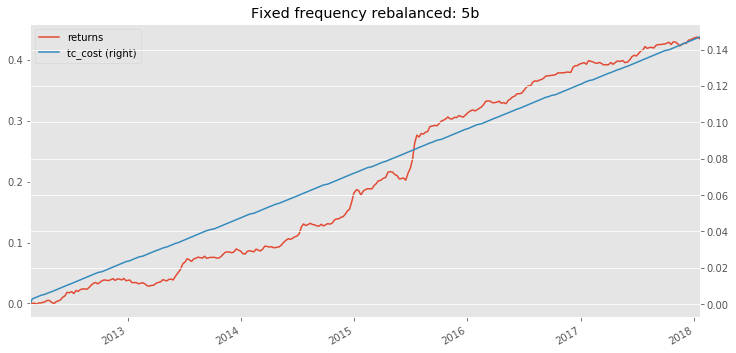

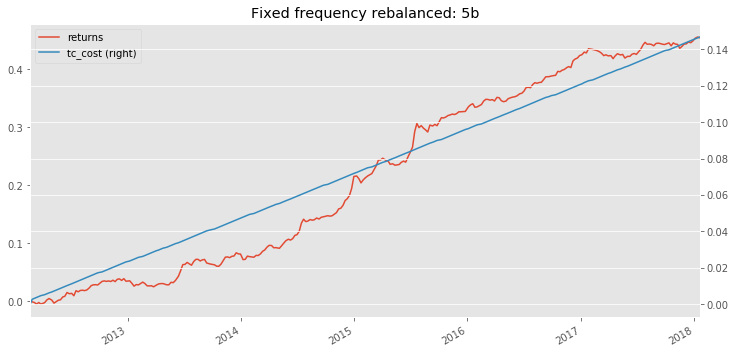

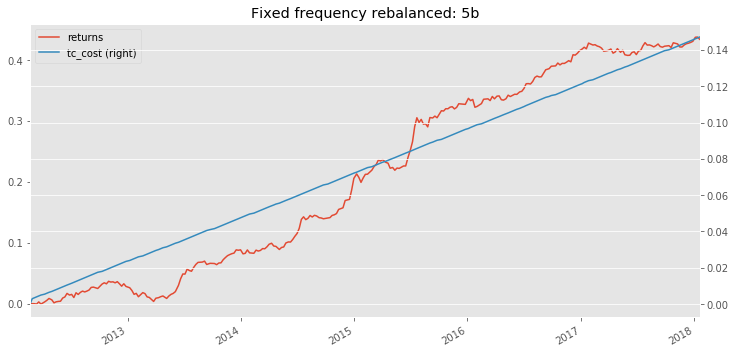

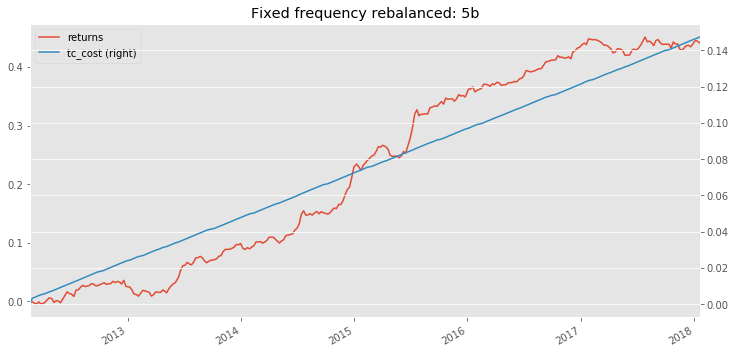

In [54]:
# Predicting and re-balance phase

weight_gaps = [0.005, 0.010, 0.015, 0.020]

model1_weight = 1.0
model2_weight = 0.5

factor_groups = const_model_factor_data.groupby('trade_date')

for s_i, weight_gap in enumerate(weight_gaps):
    print("start {0} weight gap simulation ...".format(weight_gap))

    rets = []
    turn_overs = []
    leverags = []
    previous_pos = pd.DataFrame()

    index_dates = []

    for i, value in enumerate(factor_groups):
        date = value[0]
        data = value[1]
        ref_date = date.strftime('%Y-%m-%d')

        total_data = data.fillna(data[model_features_keys].median())
        alpha_logger.info('{0}: {1}'.format(date, len(total_data)))
        risk_exp = total_data[neutralize_risk].values.astype(float)
        industry = total_data.industry_code.values
        benchmark_w = total_data.weight.values

        constraint_exp = total_data[constraint_risk].values
        risk_exp_expand = np.concatenate((constraint_exp, np.ones((len(risk_exp), 1))), axis=1).astype(float)

        risk_names = constraint_risk + ['total']
        risk_target = risk_exp_expand.T @ benchmark_w

        lbound = np.maximum(0., benchmark_w - weight_gap)  # np.zeros(len(total_data))
        ubound = weight_gap + benchmark_w

        is_in_benchmark = (benchmark_w > 0.).astype(float)

        risk_exp_expand = np.concatenate((risk_exp_expand, is_in_benchmark.reshape((-1, 1))), axis=1).astype(float)
        risk_names.append('benchmark_total')

        constraint = Constraints(risk_exp_expand, risk_names)

        for j, name in enumerate(risk_names):
            if name == 'total':
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j],
                                           upper_bound=risk_target[j])
            elif name == 'SIZE':
                base_target = abs(risk_target[j])
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] + base_target * size_risk_lower,
                                           upper_bound=risk_target[j] + base_target * size_risk_upper)
            elif name == 'benchmark_total':
                base_target = benchmark_w.sum()
                constraint.set_constraints(name,
                                           lower_bound=benchmark_total_lower * base_target,
                                           upper_bound=benchmark_total_upper * base_target)
            else:
                constraint.set_constraints(name,
                                           lower_bound=risk_target[j] * industry_lower,
                                           upper_bound=risk_target[j] * industry_upper)
        
        factor_values = factor_processing(total_data[model_features_keys].values,
                                          pre_process=[winsorize_normal, standardize],
                                          risk_factors=risk_exp,
                                          post_process=[winsorize_normal, standardize])

        # const linear model
        er1 = const_model.predict(factor_values)
        
        try:
            model = lasso_models_series.ix[date]
        except KeyError:
            alpha_logger.info("model is not available. Omit this date")
            continue
            
        index_dates.append(date)

        x = predict_x[date]
        this_predict_code = predict_code[date]
        er2 = model.predict(x)

        # combine model
        er1_table = pd.DataFrame({'er1': er1, 'code': total_data.code.values})
        er2_table = pd.DataFrame({'er2': er2, 'code': this_predict_code})
        er_table = pd.merge(er1_table, er2_table, on=['code'], how='left').fillna(0)

        er1 = er_table.er1.values
        er2 = er_table.er2.values
        
        if er2.std() > 0:
            print('using backbone model and alpha model')
            er = model1_weight * er1 / er1.std() +  model2_weight * er2 / er2.std()
        else:
            print('using only backbone modedl')
            er = model1_weight * er1
            
        codes = total_data['code'].values

        if previous_pos.empty:
            current_position = None
            turn_over_target = None
        else:
            previous_pos.set_index('code', inplace=True)
            remained_pos = previous_pos.loc[codes]

            remained_pos.fillna(0., inplace=True)
            turn_over_target = turn_over_target_base
            current_position = remained_pos.weight.values

        try:
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  turn_over_target=turn_over_target,
                                                  current_position=current_position,
                                                  lbound=lbound,
                                                  ubound=ubound)
        except ValueError:
            alpha_logger.info('{0} full re-balance'.format(date))
            target_pos, _ = er_portfolio_analysis(er,
                                                  industry,
                                                  None,
                                                  constraint,
                                                  False,
                                                  benchmark_w,
                                                  method=method,
                                                  lbound=lbound,
                                                  ubound=ubound)

        target_pos['code'] = total_data['code'].values

        turn_over, executed_pos = executor.execute(target_pos=target_pos)

        executed_codes = executed_pos.code.tolist()
        dx_returns = engine.fetch_dx_return(date, executed_codes, horizon=horizon, offset=1)

        result = pd.merge(executed_pos, total_data[['code', 'weight']], on=['code'], how='inner')
        result = pd.merge(result, dx_returns, on=['code'])

        leverage = result.weight_x.abs().sum()

        ret = result.weight_x.values @ (np.exp(result.dx.values) - 1.)
        rets.append(np.log(1. + ret))
        executor.set_current(executed_pos)
        turn_overs.append(turn_over)
        leverags.append(leverage)

        previous_pos = executed_pos
        alpha_logger.info('{0} is finished'.format(date))

    ret_df = pd.DataFrame({'returns': rets, 'turn_over': turn_overs, 'leverage': leverags}, index=index_dates)

    # index return
    index_return = engine.fetch_dx_return_index_range(benchmark_code, start_date, end_date, horizon=horizon,
                                                      offset=1).set_index('trade_date')
    ret_df['index'] = index_return['dx']

    ret_df.loc[advanceDateByCalendar('china.sse', ref_dates[-1], frequency)] = 0.
    ret_df = ret_df.shift(1)
    ret_df.iloc[0] = 0.
    ret_df['tc_cost'] = ret_df.turn_over * 0.002
    ret_df['returns'] = ret_df['leverage'] * (ret_df['returns'] - ret_df['index'])

    ret_df[['returns', 'tc_cost']].cumsum().plot(figsize=(12, 6),
                                                 title='Fixed frequency rebalanced: {0}'.format(frequency),
                                                 secondary_y='tc_cost')

    ret_df['ret_after_tc'] = ret_df['returns'] - ret_df['tc_cost']
    

    sharp_calc = MovingSharp(49)
    drawdown_calc = MovingMaxDrawdown(49)
    max_drawdown_calc = MovingMaxDrawdown(len(ret_df))

    res_df = pd.DataFrame(columns=['daily_return', 'cum_ret', 'sharp', 'drawdown', 'max_drawn', 'leverage'])

    total_returns = 0.

    for i, ret in enumerate(ret_df['ret_after_tc']):
        date = ret_df.index[i]
        total_returns += ret
        sharp_calc.push({'ret': ret, 'riskFree': 0.})
        drawdown_calc.push({'ret': ret})
        max_drawdown_calc.push({'ret': ret})

        res_df.loc[date, 'daily_return'] = ret
        res_df.loc[date, 'cum_ret'] = total_returns
        res_df.loc[date, 'drawdown'] = drawdown_calc.result()[0]
        res_df.loc[date, 'max_drawn'] = max_drawdown_calc.result()[0]
        res_df.loc[date, 'leverage'] = ret_df.loc[date, 'leverage']

        if i < 10:
            res_df.loc[date, 'sharp'] = 0.
        else:
            res_df.loc[date, 'sharp'] = sharp_calc.result() * np.sqrt(49)

    res_df.to_csv('hs300_rf_{0}.csv'.format(int(s_i)))